# Notebook 2: Data Cleaning & Exploratory Data Analysis

## Purpose
Clean the raw merged dataset (5,100 movies) to produce ~2,000-2,100 movies ready for feature engineering and modeling.

## Input
- `data/raw/movies_merged.csv` (5,100 movies, 42 columns)

## Output
- `data/processed/movies_cleaned.csv` (~2,000-2,100 movies, ~35 columns)
- `data/processed/cleaning_summary.txt` - Documentation
- Visualizations in `visualizations/` folder

## Strategy
1. **Phase 1**: Initial Assessment - Load and understand quality issues
2. **Phase 2**: Filter Unusable Rows - Remove movies without budget/revenue
3. **Phase 3**: Column Management - Drop empty/redundant columns
4. **Phase 4**: Data Type Conversions - Standardize types and categories
5. **Phase 5**: Impute Missing Values - Fill critical missing data
6. **Phase 6**: Data Validation - Ensure quality and consistency
7. **Phase 7**: Basic EDA - Answer key business questions
8. **Phase 8**: Save Cleaned Data - Export final dataset

---
## Setup and Imports

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.1


---
# PHASE 1: INITIAL ASSESSMENT
**Goal**: Load data and understand quality issues

### Cell 1: Load Data

In [5]:
# Load the merged dataset
df = pd.read_csv('data/raw/movies_merged.csv')

# Display basic info
print("=" * 80)
print("DATA LOADED SUCCESSFULLY")
print("=" * 80)
print(f"\nDataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print("\nFirst 3 rows:")
print(df.head(3))

DATA LOADED SUCCESSFULLY

Dataset shape: (5100, 37)
Rows: 5,100
Columns: 37

First 3 rows:
   tmdb_id    imdb_id       title original_title release_date  \
0    27205  tt1375666   Inception      Inception   2010-07-15   
1    10138  tt1228705  Iron Man 2     Iron Man 2   2010-04-28   
2    38757  tt0398286     Tangled        Tangled   2010-11-24   

            us_release_date us_certification     budget    revenue  runtime  \
0  2010-07-16T00:00:00.000Z            PG-13  160000000  839030630      148   
1  2010-05-07T00:00:00.000Z            PG-13  200000000  623933331      124   
2  2010-11-24T00:00:00.000Z               PG  260000000  592461732      100   

                             genres primary_genre  num_genres  popularity  \
0  Action|Science Fiction|Adventure        Action           3       26.12   
1  Adventure|Action|Science Fiction     Adventure           3       25.97   
2        Animation|Family|Adventure     Animation           3       23.21   

   vote_average  vote_

### Cell 2: Data Quality Report

In [3]:
# Generate comprehensive data quality report
print("=" * 80)
print("DATA QUALITY REPORT")
print("=" * 80)

# Missing values analysis
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
}).sort_values('Missing_Percent', ascending=False).reset_index(drop=True)

print("\nMISSING VALUES BY COLUMN:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Data types
print("\n" + "=" * 80)
print("DATA TYPES SUMMARY:")
print(df.dtypes.value_counts())

# Duplicates
print("\n" + "=" * 80)
print(f"Duplicate rows (all columns): {df.duplicated().sum()}")
print(f"Duplicate tmdb_id: {df['tmdb_id'].duplicated().sum()}")

# Summary statistics for key numeric columns
print("\n" + "=" * 80)
print("SUMMARY STATISTICS (KEY NUMERIC COLUMNS):")
key_cols = ['budget', 'revenue_worldwide', 'domestic_total', 'opening_weekend', 'runtime']
print(df[key_cols].describe())

DATA QUALITY REPORT

MISSING VALUES BY COLUMN:
                          Column  Missing_Count  Missing_Percent Data_Type
0             days_since_trailer           5100           100.00   float64
1               franchise_number           5100           100.00   float64
2               opening_theaters           5100           100.00   float64
3                   max_theaters           5100           100.00   float64
4                is_wide_release           5100           100.00   float64
5                 franchise_name           5100           100.00   float64
6                      is_sequel           5100           100.00   float64
7   years_since_last_installment           5100           100.00   float64
8                  trailer_views           5100           100.00   float64
9           trailer_release_date           5100           100.00   float64
10                domestic_total           2824            55.37   float64
11              us_certification           2608      

### Cell 3: Visualize Missing Data

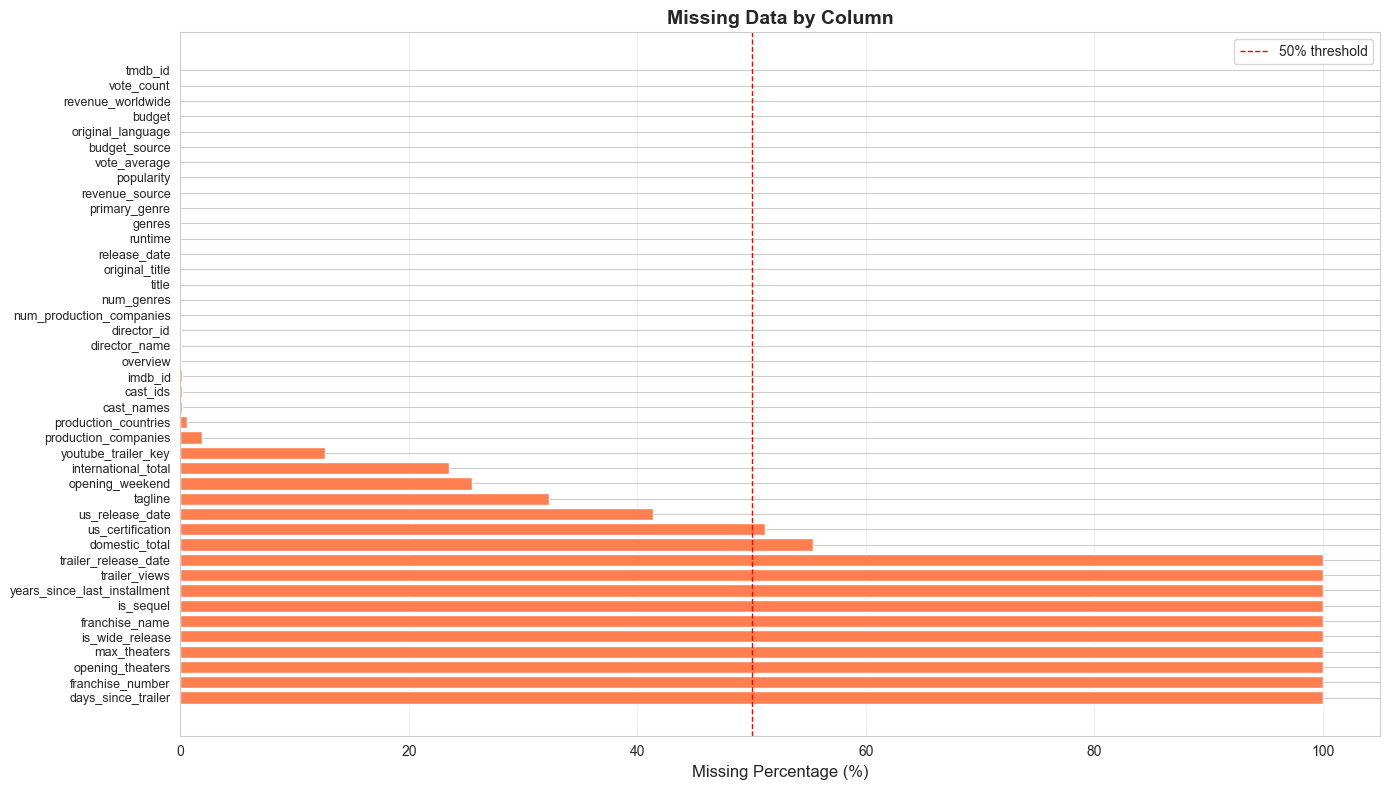

Missing data visualization saved to: visualizations/missing_data_initial.png


In [4]:
# Create missing data heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate missing percentage for each column
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

# Create bar plot
ax.barh(range(len(missing_pct)), missing_pct.values, color='coral')
ax.set_yticks(range(len(missing_pct)))
ax.set_yticklabels(missing_pct.index, fontsize=9)
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
ax.axvline(x=50, color='red', linestyle='--', linewidth=1, label='50% threshold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/missing_data_initial.png', dpi=300, bbox_inches='tight')
plt.show()

print("Missing data visualization saved to: visualizations/missing_data_initial.png")

### Cell 4: Document Findings

In [5]:
# Analyze usable data
print("=" * 80)
print("KEY FINDINGS - DATA USABILITY")
print("=" * 80)

# Critical columns for modeling
total_movies = len(df)
has_budget = (df['budget'] > 0).sum()
has_revenue = (df['revenue_worldwide'] > 0).sum()
has_both = ((df['budget'] > 0) & (df['revenue_worldwide'] > 0)).sum()

print(f"\nTotal movies in dataset: {total_movies:,}")
print(f"\nMovies with budget > 0: {has_budget:,} ({has_budget/total_movies*100:.1f}%)")
print(f"Movies with revenue > 0: {has_revenue:,} ({has_revenue/total_movies*100:.1f}%)")
print(f"Movies with BOTH budget AND revenue > 0: {has_both:,} ({has_both/total_movies*100:.1f}%)")

# Identify empty placeholder columns (100% missing)
empty_cols = missing_df[missing_df['Missing_Percent'] == 100]['Column'].tolist()
print(f"\n" + "=" * 80)
print(f"Empty placeholder columns (100% missing): {len(empty_cols)}")
print(empty_cols)

# Columns to potentially drop
high_missing = missing_df[missing_df['Missing_Percent'] > 50]['Column'].tolist()
print(f"\nColumns with >50% missing: {len(high_missing)}")
print(high_missing)

# Decision summary
print("\n" + "=" * 80)
print("CLEANING STRATEGY:")
print("=" * 80)
print("1. DROP ROWS: Missing budget OR revenue (cannot be used for modeling)")
print(f"   Expected to keep: ~{has_both:,} movies")
print("\n2. DROP COLUMNS:")
print(f"   - {len(empty_cols)} empty placeholder columns")
print("   - original_title (redundant with title)")
print("   - tagline, overview (text data for later analysis)")
print("\n3. IMPUTE: Runtime, opening_weekend, domestic_total, us_certification")
print("\n4. VALIDATE: Data types, ranges, logical consistency")

KEY FINDINGS - DATA USABILITY

Total movies in dataset: 5,100

Movies with budget > 0: 2,258 (44.3%)
Movies with revenue > 0: 4,038 (79.2%)
Movies with BOTH budget AND revenue > 0: 2,097 (41.1%)

Empty placeholder columns (100% missing): 10
['days_since_trailer', 'franchise_number', 'opening_theaters', 'max_theaters', 'is_wide_release', 'franchise_name', 'is_sequel', 'years_since_last_installment', 'trailer_views', 'trailer_release_date']

Columns with >50% missing: 12
['days_since_trailer', 'franchise_number', 'opening_theaters', 'max_theaters', 'is_wide_release', 'franchise_name', 'is_sequel', 'years_since_last_installment', 'trailer_views', 'trailer_release_date', 'domestic_total', 'us_certification']

CLEANING STRATEGY:
1. DROP ROWS: Missing budget OR revenue (cannot be used for modeling)
   Expected to keep: ~2,097 movies

2. DROP COLUMNS:
   - 10 empty placeholder columns
   - original_title (redundant with title)
   - tagline, overview (text data for later analysis)

3. IMPUTE: 

---
# PHASE 2: FILTER UNUSABLE ROWS
**Goal**: Remove movies that can't be used for modeling

### Cell 5: Filter Revenue > 0

In [6]:
# Track initial count
initial_count = len(df)

# Filter for revenue > 0
df = df[df['revenue_worldwide'] > 0].copy()

# Report
print("=" * 80)
print("STEP 1: FILTER REVENUE > 0")
print("=" * 80)
print(f"Before: {initial_count:,} movies")
print(f"After:  {len(df):,} movies")
print(f"Dropped: {initial_count - len(df):,} movies ({(initial_count - len(df))/initial_count*100:.1f}%)")
print(f"\nRemaining: {len(df):,} movies with revenue data")

STEP 1: FILTER REVENUE > 0
Before: 5,100 movies
After:  4,038 movies
Dropped: 1,062 movies (20.8%)

Remaining: 4,038 movies with revenue data


### Cell 6: Filter Budget > 0

In [7]:
# Track count before budget filter
before_budget = len(df)

# Filter for budget > 0
df = df[df['budget'] > 0].copy()

# Report
print("=" * 80)
print("STEP 2: FILTER BUDGET > 0")
print("=" * 80)
print(f"Before: {before_budget:,} movies")
print(f"After:  {len(df):,} movies")
print(f"Dropped: {before_budget - len(df):,} movies ({(before_budget - len(df))/before_budget*100:.1f}%)")
print(f"\nRemaining: {len(df):,} movies with BOTH budget AND revenue")

STEP 2: FILTER BUDGET > 0
Before: 4,038 movies
After:  2,097 movies
Dropped: 1,941 movies (48.1%)

Remaining: 2,097 movies with BOTH budget AND revenue


### Cell 7: Remove Duplicates

In [8]:
# Check for duplicates
before_dedup = len(df)
duplicates = df['tmdb_id'].duplicated().sum()

# Remove duplicates (keep first occurrence)
df = df.drop_duplicates(subset='tmdb_id', keep='first').copy()

# Report
print("=" * 80)
print("STEP 3: REMOVE DUPLICATES BY TMDB_ID")
print("=" * 80)
print(f"Duplicate tmdb_id found: {duplicates}")
print(f"Before: {before_dedup:,} movies")
print(f"After:  {len(df):,} movies")
print(f"Dropped: {before_dedup - len(df):,} duplicates")

STEP 3: REMOVE DUPLICATES BY TMDB_ID
Duplicate tmdb_id found: 0
Before: 2,097 movies
After:  2,097 movies
Dropped: 0 duplicates


### Cell 8: Filter Time Range and Summary

In [9]:
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Extract year
df['release_year'] = df['release_date'].dt.year

# Check year distribution before filter
print("Year distribution before filter:")
print(df['release_year'].value_counts().sort_index())

# Filter for 2010-2024
before_time_filter = len(df)
df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2024)].copy()

# Report
print("\n" + "=" * 80)
print("STEP 4: FILTER TIME RANGE (2010-2024)")
print("=" * 80)
print(f"Before: {before_time_filter:,} movies")
print(f"After:  {len(df):,} movies")
print(f"Dropped: {before_time_filter - len(df):,} movies outside 2010-2024")

# Phase 2 summary
print("\n" + "=" * 80)
print("PHASE 2 COMPLETE - ROW FILTERING SUMMARY")
print("=" * 80)
print(f"Original dataset: {initial_count:,} movies")
print(f"Final dataset:    {len(df):,} movies")
print(f"Total dropped:    {initial_count - len(df):,} movies ({(initial_count - len(df))/initial_count*100:.1f}%)")
print(f"\nYear range: {df['release_year'].min():.0f} - {df['release_year'].max():.0f}")
print(f"All movies have budget > 0 AND revenue > 0: ✓")

Year distribution before filter:
release_year
2010    177
2011    181
2012    154
2013    159
2014    162
2015    131
2016    146
2017    139
2018    129
2019    127
2020     79
2021    108
2022    117
2023    143
2024    145
Name: count, dtype: int64

STEP 4: FILTER TIME RANGE (2010-2024)
Before: 2,097 movies
After:  2,097 movies
Dropped: 0 movies outside 2010-2024

PHASE 2 COMPLETE - ROW FILTERING SUMMARY
Original dataset: 5,100 movies
Final dataset:    2,097 movies
Total dropped:    3,003 movies (58.9%)

Year range: 2010 - 2024
All movies have budget > 0 AND revenue > 0: ✓


---
# PHASE 3: COLUMN MANAGEMENT
**Goal**: Drop unnecessary columns

### Cell 9: Drop Empty Placeholder Columns

In [10]:
# Identify truly empty columns (100% missing)
empty_cols = df.columns[df.isnull().all()].tolist()

# Expected empty placeholders from plan
placeholder_cols = [
    'opening_theaters', 'max_theaters', 'is_wide_release', 'is_sequel',
    'franchise_name', 'franchise_number', 'years_since_last_installment',
    'trailer_views', 'trailer_release_date', 'days_since_trailer'
]

# Find which placeholders actually exist and are empty
cols_to_drop = [col for col in placeholder_cols if col in df.columns and col in empty_cols]

print("=" * 80)
print("STEP 5: DROP EMPTY PLACEHOLDER COLUMNS")
print("=" * 80)
print(f"Columns before: {len(df.columns)}")
print(f"\nEmpty placeholder columns to drop: {len(cols_to_drop)}")
print(cols_to_drop)

# Drop the columns
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"\nColumns after: {len(df.columns)}")
    print(f"Dropped: {len(cols_to_drop)} empty columns")
else:
    print("\nNo empty placeholder columns found to drop.")

STEP 5: DROP EMPTY PLACEHOLDER COLUMNS
Columns before: 43

Empty placeholder columns to drop: 10
['opening_theaters', 'max_theaters', 'is_wide_release', 'is_sequel', 'franchise_name', 'franchise_number', 'years_since_last_installment', 'trailer_views', 'trailer_release_date', 'days_since_trailer']

Columns after: 33
Dropped: 10 empty columns


### Cell 10: Drop Redundant Columns

In [11]:
# Redundant columns to drop
redundant_cols = ['original_title', 'tagline', 'overview']

# Check which ones exist
redundant_to_drop = [col for col in redundant_cols if col in df.columns]

print("=" * 80)
print("STEP 6: DROP REDUNDANT COLUMNS")
print("=" * 80)
print(f"Columns before: {len(df.columns)}")
print(f"\nRedundant columns to drop:")
print("- original_title (keep 'title')")
print("- tagline (descriptive text, not needed for modeling)")
print("- overview (descriptive text, could use in future NLP analysis)")

# Drop the columns
if redundant_to_drop:
    df = df.drop(columns=redundant_to_drop)
    print(f"\nColumns after: {len(df.columns)}")
    print(f"Dropped: {len(redundant_to_drop)} redundant columns")

STEP 6: DROP REDUNDANT COLUMNS
Columns before: 33

Redundant columns to drop:
- original_title (keep 'title')
- tagline (descriptive text, not needed for modeling)
- overview (descriptive text, could use in future NLP analysis)

Columns after: 30
Dropped: 3 redundant columns


### Cell 11: Assess Remaining Missing Data

In [12]:
# Calculate missing data for remaining columns
missing_after_cleanup = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percent', ascending=False)

print("=" * 80)
print("STEP 7: ASSESS REMAINING MISSING DATA")
print("=" * 80)
print(f"\nTotal columns: {len(df.columns)}")
print(f"Total rows: {len(df):,}")

print("\nColumns with missing data:")
print(missing_after_cleanup[missing_after_cleanup['Missing_Count'] > 0])

STEP 7: ASSESS REMAINING MISSING DATA

Total columns: 30
Total rows: 2,097

Columns with missing data:
                                    Column  Missing_Count  Missing_Percent
domestic_total              domestic_total            472            22.51
us_certification          us_certification            470            22.41
us_release_date            us_release_date            341            16.26
youtube_trailer_key    youtube_trailer_key            115             5.48
opening_weekend            opening_weekend             89             4.24
international_total    international_total             43             2.05
production_companies  production_companies              5             0.24
cast_ids                          cast_ids              2             0.10
cast_names                      cast_names              2             0.10
imdb_id                            imdb_id              1             0.05


### Cell 12: Document Strategy for Each Column

In [13]:
# Strategy for handling each column with missing data
print("=" * 80)
print("IMPUTATION STRATEGY FOR REMAINING MISSING DATA")
print("=" * 80)

strategy = {
    'runtime': 'Impute with median by primary_genre',
    'opening_weekend': 'Impute with median by genre + budget quartile (+ create missing flag)',
    'domestic_total': 'Estimate as 40% of worldwide revenue (+ create missing flag)',
    'international_total': 'Calculate as revenue_worldwide - domestic_total',
    'us_certification': 'Impute with mode by primary_genre',
    'us_release_date': 'Fill with release_date if missing',
    'director_name': 'Keep as-is, handle in feature engineering',
    'director_id': 'Keep as-is, handle in feature engineering',
    'cast_names': 'Keep as-is, handle in feature engineering',
    'cast_ids': 'Keep as-is, handle in feature engineering',
    'youtube_trailer_key': 'Keep as missing (will collect later)',
    'primary_genre': 'Fill from genres column if possible'
}

for col, strat in strategy.items():
    if col in df.columns:
        missing_pct = df[col].isnull().sum() / len(df) * 100
        print(f"\n{col}:")
        print(f"  Missing: {missing_pct:.1f}%")
        print(f"  Strategy: {strat}")

IMPUTATION STRATEGY FOR REMAINING MISSING DATA

runtime:
  Missing: 0.0%
  Strategy: Impute with median by primary_genre

opening_weekend:
  Missing: 4.2%
  Strategy: Impute with median by genre + budget quartile (+ create missing flag)

domestic_total:
  Missing: 22.5%
  Strategy: Estimate as 40% of worldwide revenue (+ create missing flag)

international_total:
  Missing: 2.1%
  Strategy: Calculate as revenue_worldwide - domestic_total

us_certification:
  Missing: 22.4%
  Strategy: Impute with mode by primary_genre

us_release_date:
  Missing: 16.3%
  Strategy: Fill with release_date if missing

director_name:
  Missing: 0.0%
  Strategy: Keep as-is, handle in feature engineering

director_id:
  Missing: 0.0%
  Strategy: Keep as-is, handle in feature engineering

cast_names:
  Missing: 0.1%
  Strategy: Keep as-is, handle in feature engineering

cast_ids:
  Missing: 0.1%
  Strategy: Keep as-is, handle in feature engineering

youtube_trailer_key:
  Missing: 5.5%
  Strategy: Keep as mis

---
# PHASE 4: DATA TYPE CONVERSIONS
**Goal**: Standardize data types and categorical values

### Cell 13: Fix Data Types

In [14]:
print("=" * 80)
print("STEP 8: FIX DATA TYPES")
print("=" * 80)

# Numeric columns
numeric_cols = ['budget', 'revenue_worldwide', 'domestic_total', 'opening_weekend', 
                'international_total', 'runtime', 'popularity', 'vote_average', 'vote_count',
                'num_genres', 'num_production_companies']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Date columns
date_cols = ['release_date', 'us_release_date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# ID columns to integer
id_cols = ['tmdb_id', 'director_id']
for col in id_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# Categorical columns remain as strings for now
print("Data types fixed:")
print(f"- {len(numeric_cols)} numeric columns")
print(f"- {len(date_cols)} date columns")
print(f"- {len(id_cols)} ID columns")
print("\nData types summary:")
print(df.dtypes.value_counts())

STEP 8: FIX DATA TYPES
Data types fixed:
- 11 numeric columns
- 2 date columns
- 2 ID columns

Data types summary:
object                 14
float64                 7
int64                   4
Int64                   2
datetime64[ns]          1
datetime64[ns, UTC]     1
int32                   1
Name: count, dtype: int64


### Cell 14: Standardize US Certification

In [15]:
print("=" * 80)
print("STEP 9: STANDARDIZE US CERTIFICATION")
print("=" * 80)

# Check current values
print("\nCurrent us_certification values:")
print(df['us_certification'].value_counts(dropna=False))

# Standardize ratings
rating_map = {
    'G': 'G',
    'PG': 'PG', 
    'PG-13': 'PG-13',
    'R': 'R',
    'NC-17': 'NC-17',
    'NR': 'Not Rated',
    'Not Rated': 'Not Rated',
    'Unrated': 'Not Rated'
}

# Apply mapping
if 'us_certification' in df.columns:
    df['us_certification'] = df['us_certification'].map(rating_map).fillna('Not Rated')
    
    print("\nStandardized us_certification values:")
    print(df['us_certification'].value_counts(dropna=False))
    
    # For any remaining missing, impute with mode by genre
    missing_cert = df['us_certification'].isnull().sum()
    if missing_cert > 0:
        print(f"\nImputing {missing_cert} missing certifications with genre mode...")
        genre_cert_mode = df.groupby('primary_genre')['us_certification'].apply(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else 'PG-13'
        )
        df['us_certification'] = df.apply(
            lambda row: genre_cert_mode.get(row['primary_genre'], 'PG-13') 
            if pd.isna(row['us_certification']) else row['us_certification'],
            axis=1
        )

STEP 9: STANDARDIZE US CERTIFICATION

Current us_certification values:
us_certification
R        727
PG-13    560
NaN      470
PG       234
NR        83
G         19
NC-17      4
Name: count, dtype: int64

Standardized us_certification values:
us_certification
R            727
PG-13        560
Not Rated    553
PG           234
G             19
NC-17          4
Name: count, dtype: int64


### Cell 15: Standardize Primary Genre

In [16]:
print("=" * 80)
print("STEP 10: STANDARDIZE PRIMARY GENRE")
print("=" * 80)

# Check current primary_genre
print("\nPrimary genre distribution:")
print(df['primary_genre'].value_counts())
print(f"\nMissing primary_genre: {df['primary_genre'].isnull().sum()}")

# Fill missing primary_genre from genres column
def extract_first_genre(genres_str):
    if pd.isna(genres_str):
        return 'Unknown'
    # Genres are pipe-separated: "Action|Adventure|Sci-Fi"
    return str(genres_str).split('|')[0].strip()

# Fill missing primary_genre
missing_mask = df['primary_genre'].isnull()
if missing_mask.sum() > 0:
    df.loc[missing_mask, 'primary_genre'] = df.loc[missing_mask, 'genres'].apply(extract_first_genre)
    print(f"\nFilled {missing_mask.sum()} missing primary_genre values from genres column")

print("\nFinal primary_genre distribution:")
print(df['primary_genre'].value_counts())

STEP 10: STANDARDIZE PRIMARY GENRE

Primary genre distribution:
primary_genre
Action             444
Drama              399
Comedy             284
Horror             185
Animation          120
Adventure          108
Thriller           105
Crime               86
Science Fiction     83
Family              63
Fantasy             59
Romance             58
War                 30
History             26
Mystery             21
Music               14
Western              7
Documentary          5
Name: count, dtype: int64

Missing primary_genre: 0

Final primary_genre distribution:
primary_genre
Action             444
Drama              399
Comedy             284
Horror             185
Animation          120
Adventure          108
Thriller           105
Crime               86
Science Fiction     83
Family              63
Fantasy             59
Romance             58
War                 30
History             26
Mystery             21
Music               14
Western              7
Documentary     

### Cell 16: Handle US Release Date and Create Language Feature

In [17]:
print("=" * 80)
print("STEP 11: HANDLE US RELEASE DATE AND CREATE LANGUAGE FEATURE")
print("=" * 80)

# Fill missing us_release_date with release_date
missing_us_date = df['us_release_date'].isnull().sum()
print(f"Missing us_release_date: {missing_us_date}")

if missing_us_date > 0:
    df['us_release_date'].fillna(df['release_date'], inplace=True)
    print(f"Filled {missing_us_date} missing us_release_date with release_date")

# Create is_english binary feature
df['is_english'] = (df['original_language'] == 'en').astype(int)
print(f"\nCreated 'is_english' feature:")
print(df['is_english'].value_counts())
print(f"English language movies: {df['is_english'].sum()} ({df['is_english'].mean()*100:.1f}%)")

# Create release_month feature
df['release_month'] = df['release_date'].dt.month
print(f"\nCreated 'release_month' feature")
print(df['release_month'].value_counts().sort_index())

STEP 11: HANDLE US RELEASE DATE AND CREATE LANGUAGE FEATURE
Missing us_release_date: 341
Filled 341 missing us_release_date with release_date

Created 'is_english' feature:
is_english
1    1543
0     554
Name: count, dtype: int64
English language movies: 1543 (73.6%)

Created 'release_month' feature
release_month
1     128
2     138
3     181
4     140
5     168
6     157
7     164
8     195
9     228
10    219
11    177
12    202
Name: count, dtype: int64


---
# PHASE 5: IMPUTE MISSING VALUES
**Goal**: Fill critical missing values with reasonable estimates

### Cell 17: Impute Runtime

In [18]:
print("=" * 80)
print("STEP 12: IMPUTE RUNTIME")
print("=" * 80)

missing_runtime = df['runtime'].isnull().sum()
print(f"Missing runtime: {missing_runtime} ({missing_runtime/len(df)*100:.1f}%)")

if missing_runtime > 0:
    # Calculate median runtime by genre
    genre_runtime_median = df.groupby('primary_genre')['runtime'].median()
    overall_median = df['runtime'].median()
    
    print(f"\nMedian runtime by genre:")
    print(genre_runtime_median.sort_values(ascending=False))
    print(f"\nOverall median runtime: {overall_median}")
    
    # Impute missing values
    def impute_runtime(row):
        if pd.isna(row['runtime']):
            # Use genre median, fallback to overall median
            return genre_runtime_median.get(row['primary_genre'], overall_median)
        return row['runtime']
    
    df['runtime'] = df.apply(impute_runtime, axis=1)
    print(f"\nImputed {missing_runtime} missing runtime values")
    print(f"Remaining missing: {df['runtime'].isnull().sum()}")

STEP 12: IMPUTE RUNTIME
Missing runtime: 0 (0.0%)


### Cell 18: Impute Opening Weekend

In [19]:
print("=" * 80)
print("STEP 13: IMPUTE OPENING WEEKEND")
print("=" * 80)

missing_opening = df['opening_weekend'].isnull().sum()
print(f"Missing opening_weekend: {missing_opening} ({missing_opening/len(df)*100:.1f}%)")

# Create missing indicator first
df['opening_weekend_missing'] = df['opening_weekend'].isnull().astype(int)
print(f"Created 'opening_weekend_missing' indicator")

if missing_opening > 0:
    # Create budget quartiles for better imputation
    df['budget_quartile'] = pd.qcut(df['budget'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    # Calculate median by genre and budget quartile
    genre_budget_median = df.groupby(['primary_genre', 'budget_quartile'])['opening_weekend'].median()
    genre_median = df.groupby('primary_genre')['opening_weekend'].median()
    overall_median = df['opening_weekend'].median()
    
    # Impute with hierarchy: genre+budget -> genre -> overall
    def impute_opening(row):
        if pd.isna(row['opening_weekend']):
            # Try genre + budget quartile
            val = genre_budget_median.get((row['primary_genre'], row['budget_quartile']), None)
            if pd.isna(val) or val is None:
                # Try genre only
                val = genre_median.get(row['primary_genre'], overall_median)
            return val
        return row['opening_weekend']
    
    df['opening_weekend'] = df.apply(impute_opening, axis=1)
    print(f"\nImputed {missing_opening} missing opening_weekend values")
    print(f"Strategy: Genre + Budget Quartile -> Genre -> Overall Median")
    print(f"Remaining missing: {df['opening_weekend'].isnull().sum()}")
    
    # Drop temporary budget_quartile column
    df = df.drop(columns=['budget_quartile'])

STEP 13: IMPUTE OPENING WEEKEND
Missing opening_weekend: 89 (4.2%)
Created 'opening_weekend_missing' indicator

Imputed 89 missing opening_weekend values
Strategy: Genre + Budget Quartile -> Genre -> Overall Median
Remaining missing: 0


### Cell 19: Impute Domestic Total

In [20]:
print("=" * 80)
print("STEP 14: IMPUTE DOMESTIC TOTAL")
print("=" * 80)

missing_domestic = df['domestic_total'].isnull().sum()
print(f"Missing domestic_total: {missing_domestic} ({missing_domestic/len(df)*100:.1f}%)")

# Create missing indicator
df['domestic_total_missing'] = df['domestic_total'].isnull().astype(int)
print(f"Created 'domestic_total_missing' indicator")

if missing_domestic > 0:
    # Calculate average domestic/worldwide ratio for movies with both
    has_both = df[df['domestic_total'].notna() & df['revenue_worldwide'].notna()]
    avg_domestic_ratio = (has_both['domestic_total'] / has_both['revenue_worldwide']).mean()
    
    print(f"\nAverage domestic/worldwide ratio: {avg_domestic_ratio:.2%}")
    print(f"Using 40% as conservative estimate for missing values")
    
    # Impute as 40% of worldwide revenue
    df.loc[df['domestic_total'].isnull(), 'domestic_total'] = (
        df.loc[df['domestic_total'].isnull(), 'revenue_worldwide'] * 0.40
    )
    
    print(f"\nImputed {missing_domestic} missing domestic_total values (40% of worldwide)")
    print(f"Remaining missing: {df['domestic_total'].isnull().sum()}")

STEP 14: IMPUTE DOMESTIC TOTAL
Missing domestic_total: 472 (22.5%)
Created 'domestic_total_missing' indicator

Average domestic/worldwide ratio: 40.59%
Using 40% as conservative estimate for missing values

Imputed 472 missing domestic_total values (40% of worldwide)
Remaining missing: 0


### Cell 20: Calculate International Total

In [21]:
print("=" * 80)
print("STEP 15: CALCULATE INTERNATIONAL TOTAL")
print("=" * 80)

# Calculate international as worldwide - domestic
df['international_total'] = df['revenue_worldwide'] - df['domestic_total']

# Ensure no negative values (data quality issue)
negative_intl = (df['international_total'] < 0).sum()
if negative_intl > 0:
    print(f"Found {negative_intl} movies with negative international total")
    print("Setting negative values to 0...")
    df.loc[df['international_total'] < 0, 'international_total'] = 0

print(f"\nInternational total statistics:")
print(df['international_total'].describe())
print(f"\nMissing international_total: {df['international_total'].isnull().sum()}")

STEP 15: CALCULATE INTERNATIONAL TOTAL

International total statistics:
count         2097.00
mean      95467254.42
std      175611015.34
min              0.00
25%        2451657.60
50%       23245855.00
75%      103449000.00
max     1941066100.00
Name: international_total, dtype: float64

Missing international_total: 0


### Cell 21: Final Missing Check

In [22]:
print("=" * 80)
print("STEP 16: FINAL MISSING VALUES CHECK")
print("=" * 80)

# Calculate missing for all columns
final_missing = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percent', ascending=False)

print("\nColumns with missing data:")
missing_cols = final_missing[final_missing['Missing_Count'] > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("No missing data! ✓")

# Check critical columns
critical_cols = ['budget', 'revenue_worldwide', 'domestic_total', 'runtime', 
                 'primary_genre', 'release_date', 'us_certification']
print("\n" + "=" * 80)
print("CRITICAL COLUMNS CHECK:")
for col in critical_cols:
    if col in df.columns:
        missing = df[col].isnull().sum()
        status = "✓" if missing == 0 else "✗"
        print(f"{status} {col}: {missing} missing ({missing/len(df)*100:.1f}%)")

STEP 16: FINAL MISSING VALUES CHECK

Columns with missing data:
                                    Column  Missing_Count  Missing_Percent
youtube_trailer_key    youtube_trailer_key            115             5.48
production_companies  production_companies              5             0.24
cast_names                      cast_names              2             0.10
cast_ids                          cast_ids              2             0.10
imdb_id                            imdb_id              1             0.05

CRITICAL COLUMNS CHECK:
✓ budget: 0 missing (0.0%)
✓ revenue_worldwide: 0 missing (0.0%)
✓ domestic_total: 0 missing (0.0%)
✓ runtime: 0 missing (0.0%)
✓ primary_genre: 0 missing (0.0%)
✓ release_date: 0 missing (0.0%)
✓ us_certification: 0 missing (0.0%)


---
# PHASE 6: DATA VALIDATION
**Goal**: Ensure data quality and logical consistency

### Cell 22: Validate Numeric Ranges

In [23]:
print("=" * 80)
print("STEP 17: VALIDATE NUMERIC RANGES")
print("=" * 80)

# Check budget ranges
print("\nBUDGET VALIDATION:")
print(f"Min budget: ${df['budget'].min():,.0f}")
print(f"Max budget: ${df['budget'].max():,.0f}")
print(f"Mean budget: ${df['budget'].mean():,.0f}")
print(f"Movies with budget > $500M: {(df['budget'] > 500_000_000).sum()}")
invalid_budget = (df['budget'] <= 0).sum()
print(f"✓ All budgets > 0: {invalid_budget == 0}")

# Check revenue ranges
print("\nREVENUE VALIDATION:")
print(f"Min revenue: ${df['revenue_worldwide'].min():,.0f}")
print(f"Max revenue: ${df['revenue_worldwide'].max():,.0f}")
print(f"Mean revenue: ${df['revenue_worldwide'].mean():,.0f}")
invalid_revenue = (df['revenue_worldwide'] <= 0).sum()
print(f"✓ All revenue > 0: {invalid_revenue == 0}")

# Check runtime ranges
print("\nRUNTIME VALIDATION:")
print(f"Min runtime: {df['runtime'].min():.0f} minutes")
print(f"Max runtime: {df['runtime'].max():.0f} minutes")
print(f"Mean runtime: {df['runtime'].mean():.0f} minutes")

# Drop short films (runtime < 60 minutes)
short_films = (df['runtime'] < 60).sum()
if short_films > 0:
    print(f"\nFound {short_films} short films (runtime < 60 min) - removing...")
    before_drop = len(df)
    df = df[df['runtime'] >= 60].copy()
    print(f"Dropped {before_drop - len(df)} short films")
    print(f"Remaining movies: {len(df):,}")
else:
    print("✓ No short films found (all runtime >= 60 min)")

# Check for extremely long films (potential errors)
very_long = (df['runtime'] > 240).sum()
if very_long > 0:
    print(f"\n⚠ Warning: {very_long} movies with runtime > 240 min (4 hours)")
    print(df[df['runtime'] > 240][['title', 'runtime', 'release_year']].head(10))

STEP 17: VALIDATE NUMERIC RANGES

BUDGET VALIDATION:
Min budget: $1
Max budget: $583,900,000
Mean budget: $47,382,843
Movies with budget > $500M: 1
✓ All budgets > 0: True

REVENUE VALIDATION:
Min revenue: $15
Max revenue: $2,799,439,100
Mean revenue: $151,989,310
✓ All revenue > 0: True

RUNTIME VALIDATION:
Min runtime: 0 minutes
Max runtime: 247 minutes
Mean runtime: 113 minutes

Found 2 short films (runtime < 60 min) - removing...
Dropped 2 short films
Remaining movies: 2,095

⚠ Warning: 1 movies with runtime > 240 min (4 hours)
                                  title  runtime  release_year
423  Kill Bill: The Whole Bloody Affair      247          2011


### Cell 23: Identify Outliers (Keep Them)

In [25]:
print("=" * 80)
print("STEP 18: IDENTIFY OUTLIERS (FOR ANALYSIS - KEEP ALL)")
print("=" * 80)

# Calculate z-scores for budget and revenue
from scipy import stats

df['budget_zscore'] = np.abs(stats.zscore(df['budget']))
df['revenue_zscore'] = np.abs(stats.zscore(df['revenue_worldwide']))

# Identify statistical outliers (z-score > 3)
budget_outliers = (df['budget_zscore'] > 3).sum()
revenue_outliers = (df['revenue_zscore'] > 3).sum()

print(f"\nStatistical outliers (z-score > 3):")
print(f"Budget outliers: {budget_outliers}")
print(f"Revenue outliers: {revenue_outliers}")

# Flag blockbusters (budget >$150M OR revenue >$500M)
df['is_blockbuster'] = (
    (df['budget'] > 150_000_000) | (df['revenue_worldwide'] > 500_000_000)
).astype(int)

blockbuster_count = df['is_blockbuster'].sum()
print(f"\nBlockbusters (budget >$150M OR revenue >$500M): {blockbuster_count}")
print(f"Percentage: {blockbuster_count/len(df)*100:.1f}%")

print("\nTop 10 highest budget movies:")
print(df.nlargest(10, 'budget')[['title', 'release_year', 'budget', 'revenue_worldwide']])

print("\nTop 10 highest grossing movies:")
print(df.nlargest(10, 'revenue_worldwide')[['title', 'release_year', 'budget', 'revenue_worldwide']])

print("\n✓ KEEPING ALL OUTLIERS - they are legitimate blockbusters the model needs to learn from")

# Drop z-score columns (temporary)
df = df.drop(columns=['budget_zscore', 'revenue_zscore'])

STEP 18: IDENTIFY OUTLIERS (FOR ANALYSIS - KEEP ALL)

Statistical outliers (z-score > 3):
Budget outliers: 36
Revenue outliers: 57

Blockbusters (budget >$150M OR revenue >$500M): 248
Percentage: 11.8%

Top 10 highest budget movies:
                                      title  release_year       budget  \
4091                Jurassic World Dominion          2022 583900000.00   
3062                      Avengers: Endgame          2019 356000000.00   
4080               Avatar: The Way of Water          2022 350000000.00   
4425                                 Fast X          2023 340000000.00   
2398               Star Wars: The Last Jedi          2017 317000000.00   
4800                           Gladiator II          2024 310000000.00   
2402                         Justice League          2017 300000000.00   
2720                 Avengers: Infinity War          2018 300000000.00   
4444                     The Little Mermaid          2023 297000000.00   
4459  Indiana Jones and the

### Cell 24: Check Logical Consistency

In [26]:
print("=" * 80)
print("STEP 19: CHECK LOGICAL CONSISTENCY")
print("=" * 80)

# Check: opening_weekend <= domestic_total <= revenue_worldwide
print("\n1. Revenue Hierarchy: opening_weekend <= domestic_total <= worldwide")
opening_gt_domestic = (df['opening_weekend'] > df['domestic_total']).sum()
domestic_gt_worldwide = (df['domestic_total'] > df['revenue_worldwide']).sum()

print(f"   Opening > Domestic violations: {opening_gt_domestic}")
print(f"   Domestic > Worldwide violations: {domestic_gt_worldwide}")

# Fix violations
if opening_gt_domestic > 0:
    print(f"   Fixing {opening_gt_domestic} opening > domestic violations...")
    # Set opening_weekend = domestic_total where violation occurs
    df.loc[df['opening_weekend'] > df['domestic_total'], 'opening_weekend'] = \
        df.loc[df['opening_weekend'] > df['domestic_total'], 'domestic_total']

if domestic_gt_worldwide > 0:
    print(f"   Fixing {domestic_gt_worldwide} domestic > worldwide violations...")
    # Recalculate domestic as worldwide - international
    df.loc[df['domestic_total'] > df['revenue_worldwide'], 'domestic_total'] = \
        df.loc[df['domestic_total'] > df['revenue_worldwide'], 'revenue_worldwide'] * 0.40
    # Recalculate international
    df['international_total'] = df['revenue_worldwide'] - df['domestic_total']

# Check international = worldwide - domestic
print("\n2. International Calculation: worldwide - domestic")
intl_calculated = df['revenue_worldwide'] - df['domestic_total']
intl_mismatch = (np.abs(df['international_total'] - intl_calculated) > 1).sum()  # Allow $1 rounding
print(f"   Mismatches: {intl_mismatch}")
if intl_mismatch > 0:
    df['international_total'] = intl_calculated
    print("   ✓ Recalculated international_total")

print("\n✓ Logical consistency checks complete")

STEP 19: CHECK LOGICAL CONSISTENCY

1. Revenue Hierarchy: opening_weekend <= domestic_total <= worldwide
   Opening > Domestic violations: 146
   Domestic > Worldwide violations: 0
   Fixing 146 opening > domestic violations...

2. International Calculation: worldwide - domestic
   Mismatches: 0

✓ Logical consistency checks complete


### Cell 25: Validate Dates

In [27]:
print("=" * 80)
print("STEP 20: VALIDATE DATES")
print("=" * 80)

# Confirm all dates are in 2010-2024 range
print("\nRelease year range:")
print(f"Min year: {df['release_year'].min():.0f}")
print(f"Max year: {df['release_year'].max():.0f}")
outside_range = ((df['release_year'] < 2010) | (df['release_year'] > 2024)).sum()
print(f"✓ All movies in 2010-2024 range: {outside_range == 0}")

# Check US release within 365 days of worldwide release
print("\nUS vs Worldwide release date difference:")
date_diff = (df['us_release_date'] - df['release_date']).dt.days
print(f"Mean difference: {date_diff.mean():.1f} days")
print(f"Median difference: {date_diff.median():.1f} days")
large_diff = (np.abs(date_diff) > 365).sum()
print(f"Movies with >365 day difference: {large_diff}")

if large_diff > 0:
    print("\nMovies with large release date differences:")
    print(df[np.abs(date_diff) > 365][['title', 'release_date', 'us_release_date']].head(10))

print("\n✓ Date validation complete")

STEP 20: VALIDATE DATES

Release year range:
Min year: 2010
Max year: 2024
✓ All movies in 2010-2024 range: True

US vs Worldwide release date difference:


TypeError: cannot subtract DatetimeArray from ndarray

### Cell 26: Plot Distributions

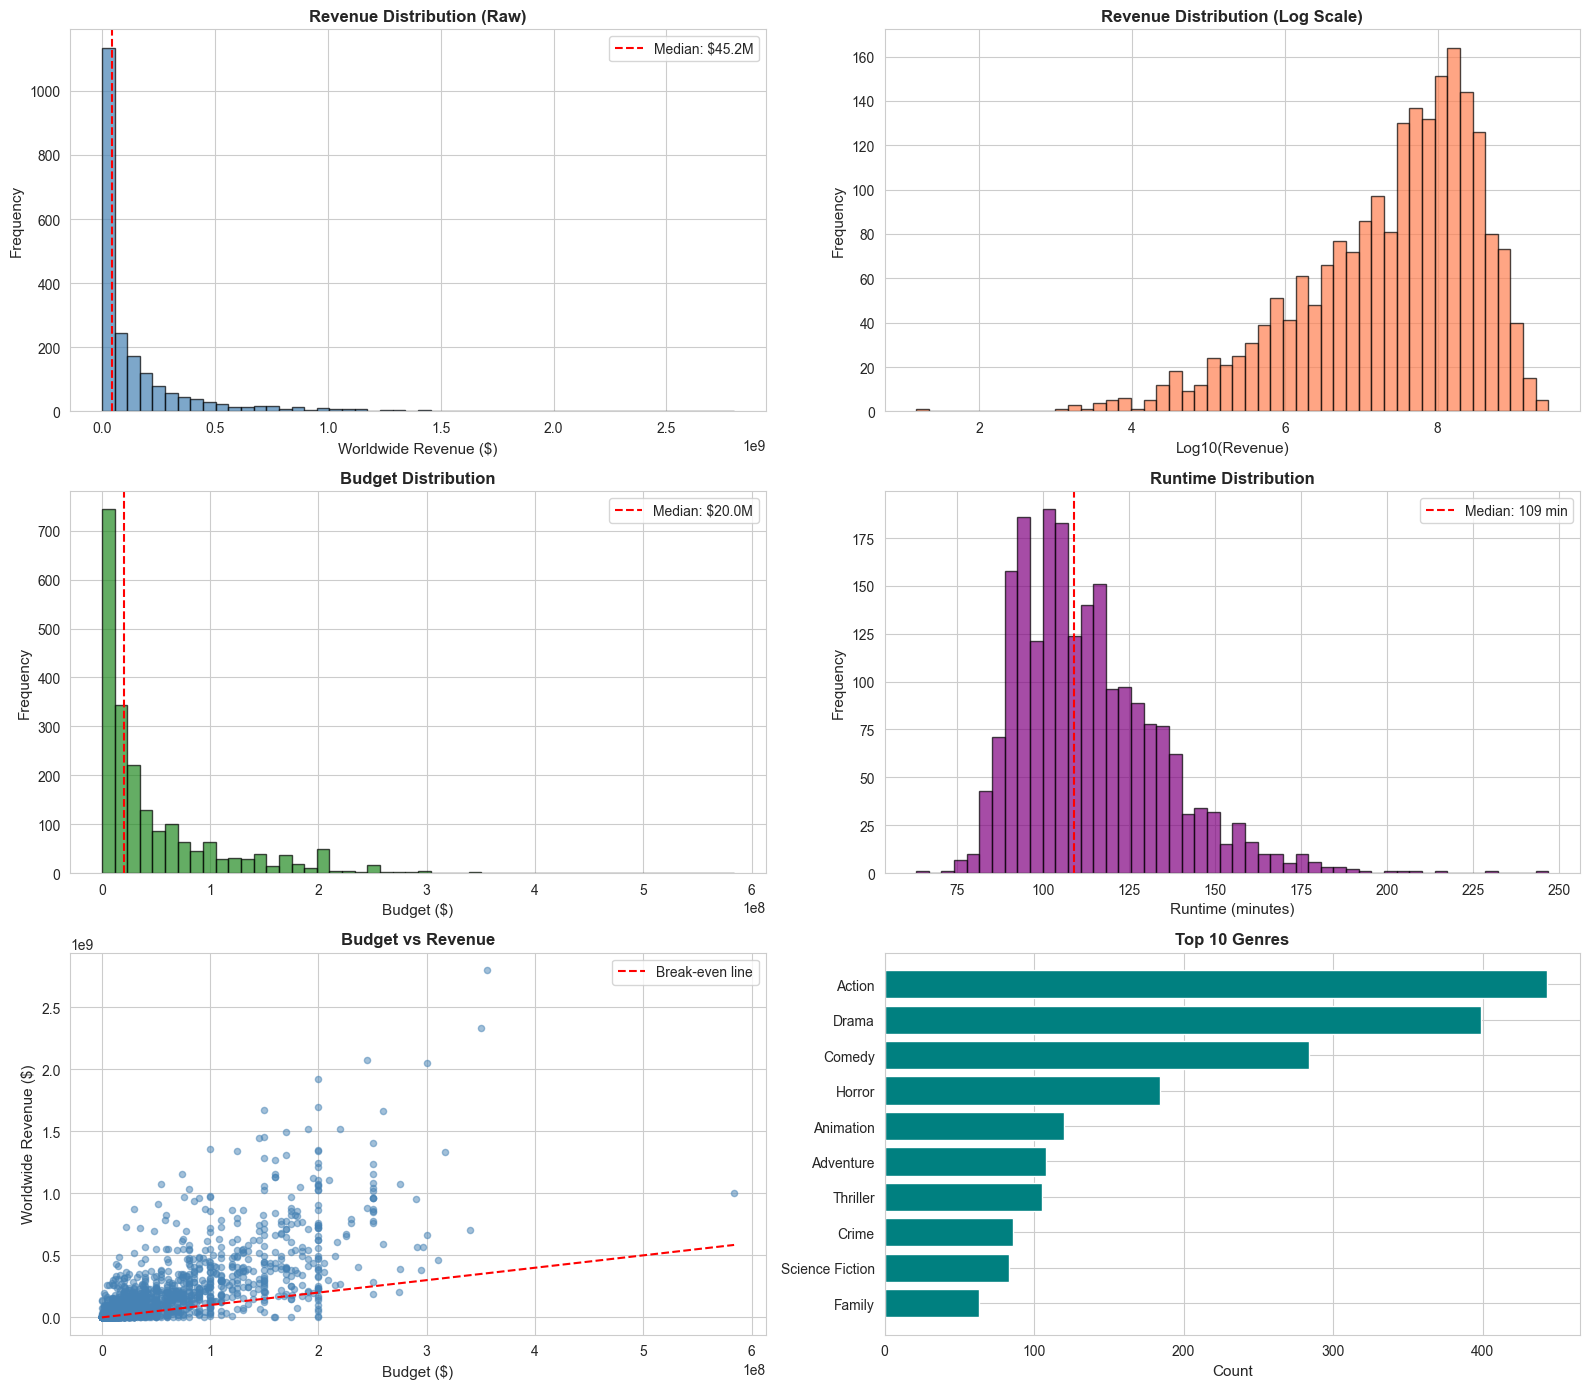

Distribution plots saved to: visualizations/data_cleaning_distributions.png


In [ ]:
# Create comprehensive distribution plots
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. Revenue distribution (raw)
axes[0, 0].hist(df['revenue_worldwide'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Worldwide Revenue ($)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Revenue Distribution (Raw)', fontsize=12, fontweight='bold')
axes[0, 0].axvline(df['revenue_worldwide'].median(), color='red', linestyle='--', label=f"Median: ${df['revenue_worldwide'].median()/1e6:.1f}M")
axes[0, 0].legend()


# 2. Revenue distribution (log scale)
axes[0, 1].hist(np.log10(df['revenue_worldwide']), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log10(Revenue)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Revenue Distribution (Log Scale)', fontsize=12, fontweight='bold')

# 3. Budget distribution
axes[1, 0].hist(df['budget'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Budget ($)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Budget Distribution', fontsize=12, fontweight='bold')
axes[1, 0].axvline(df['budget'].median(), color='red', linestyle='--', label=f"Median: ${df['budget'].median()/1e6:.1f}M")
axes[1, 0].legend()

# 4. Runtime distribution
axes[1, 1].hist(df['runtime'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Runtime (minutes)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Runtime Distribution', fontsize=12, fontweight='bold')
axes[1, 1].axvline(df['runtime'].median(), color='red', linestyle='--', label=f"Median: {df['runtime'].median():.0f} min")
axes[1, 1].legend()

# 5. Budget vs Revenue scatter
axes[2, 0].scatter(df['budget'], df['revenue_worldwide'], alpha=0.5, s=20, c='steelblue')
axes[2, 0].plot([0, df['budget'].max()], [0, df['budget'].max()], 'r--', label='Break-even line')
axes[2, 0].set_xlabel('Budget ($)', fontsize=11)
axes[2, 0].set_ylabel('Worldwide Revenue ($)', fontsize=11)
axes[2, 0].set_title('Budget vs Revenue', fontsize=12, fontweight='bold')
axes[2, 0].legend()

# 6. Top genres
genre_counts = df['primary_genre'].value_counts().head(10)
axes[2, 1].barh(range(len(genre_counts)), genre_counts.values, color='teal')
axes[2, 1].set_yticks(range(len(genre_counts)))
axes[2, 1].set_yticklabels(genre_counts.index)
axes[2, 1].set_xlabel('Count', fontsize=11)
axes[2, 1].set_title('Top 10 Genres', fontsize=12, fontweight='bold')
axes[2, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('visualizations/data_cleaning_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution plots saved to: visualizations/data_cleaning_distributions.png")

### Cell 27: Correlation Matrix

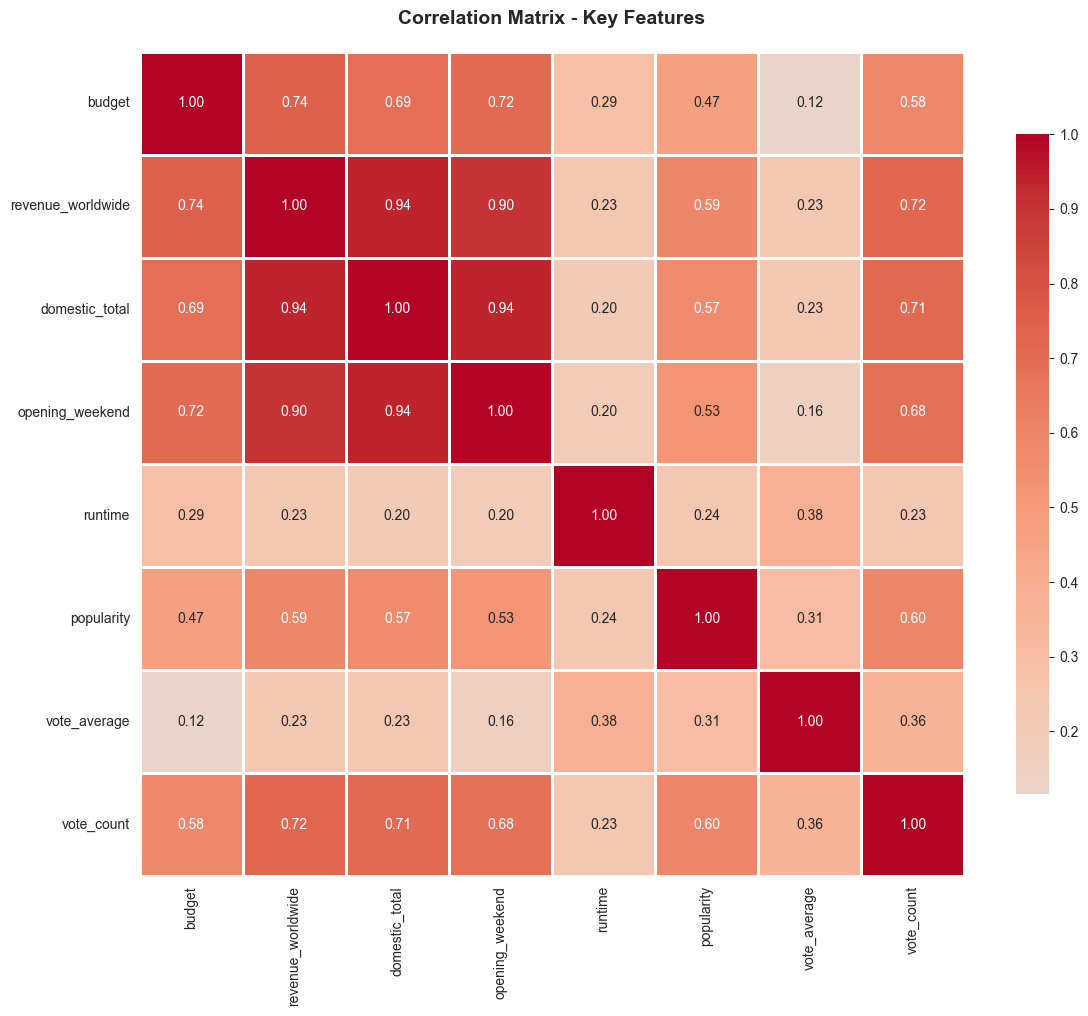

Correlation matrix saved to: visualizations/correlation_matrix_cleaned.png

Top correlations with revenue_worldwide:
revenue_worldwide   1.00
domestic_total      0.94
opening_weekend     0.90
budget              0.74
vote_count          0.72
popularity          0.59
runtime             0.23
vote_average        0.23
Name: revenue_worldwide, dtype: float64


In [29]:
# Calculate correlation matrix for key numeric features
corr_cols = ['budget', 'revenue_worldwide', 'domestic_total', 'opening_weekend', 
             'runtime', 'popularity', 'vote_average', 'vote_count']
corr_matrix = df[corr_cols].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix - Key Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualizations/correlation_matrix_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation matrix saved to: visualizations/correlation_matrix_cleaned.png")
print("\nTop correlations with revenue_worldwide:")
revenue_corr = corr_matrix['revenue_worldwide'].sort_values(ascending=False)
print(revenue_corr)

---
# PHASE 7: BASIC EDA
**Goal**: Answer key business questions

### Cell 28: Univariate Analysis - Numeric

In [30]:
print("=" * 80)
print("UNIVARIATE ANALYSIS - NUMERIC FEATURES")
print("=" * 80)

numeric_features = ['budget', 'revenue_worldwide', 'domestic_total', 'opening_weekend', 
                    'runtime', 'popularity', 'vote_average', 'vote_count']

for feature in numeric_features:
    if feature in df.columns:
        print(f"\n{feature.upper()}:")
        print(df[feature].describe())
        
        # Calculate skewness and kurtosis
        skewness = df[feature].skew()
        kurtosis = df[feature].kurtosis()
        print(f"Skewness: {skewness:.2f}")
        print(f"Kurtosis: {kurtosis:.2f}")
        
        # Interpretation
        if abs(skewness) > 1:
            print("→ Highly skewed - consider log transformation")
        elif abs(skewness) > 0.5:
            print("→ Moderately skewed")
        else:
            print("→ Approximately symmetric")

UNIVARIATE ANALYSIS - NUMERIC FEATURES

BUDGET:
count        2095.00
mean     47424688.24
std      61045861.34
min             1.00
25%       6585000.00
50%      20000000.00
75%      65000000.00
max     583900000.00
Name: budget, dtype: float64
Skewness: 2.08
Kurtosis: 5.66
→ Highly skewed - consider log transformation

REVENUE_WORLDWIDE:
count         2095.00
mean     152128030.22
std      265343893.13
min             15.00
25%        5317713.00
50%       45221814.00
75%      174362211.50
max     2799439100.00
Name: revenue_worldwide, dtype: float64
Skewness: 3.38
Kurtosis: 15.97
→ Highly skewed - consider log transformation

DOMESTIC_TOTAL:
count        2095.00
mean     56573463.84
std      98769698.26
min             6.00
25%        981249.50
50%      16279129.00
75%      67833322.50
max     936662225.00
Name: domestic_total, dtype: float64
Skewness: 3.46
Kurtosis: 16.32
→ Highly skewed - consider log transformation

OPENING_WEEKEND:
count        2095.00
mean     17142320.71
std    

### Cell 29: Univariate Analysis - Categorical

In [31]:
print("=" * 80)
print("UNIVARIATE ANALYSIS - CATEGORICAL FEATURES")
print("=" * 80)

# Primary Genre
print("\nPRIMARY GENRE:")
print(df['primary_genre'].value_counts())
print(f"Total genres: {df['primary_genre'].nunique()}")

# US Certification
print("\n" + "=" * 80)
print("US CERTIFICATION:")
print(df['us_certification'].value_counts())

# Language
print("\n" + "=" * 80)
print("ORIGINAL LANGUAGE:")
print(df['original_language'].value_counts().head(10))
print(f"\nEnglish movies: {df['is_english'].sum()} ({df['is_english'].mean()*100:.1f}%)")

# Release Year
print("\n" + "=" * 80)
print("RELEASE YEAR:")
print(df['release_year'].value_counts().sort_index())

# Release Month
print("\n" + "=" * 80)
print("RELEASE MONTH:")
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_counts = df['release_month'].value_counts().sort_index()
for month, count in month_counts.items():
    print(f"{month_names[month]}: {count}")

UNIVARIATE ANALYSIS - CATEGORICAL FEATURES

PRIMARY GENRE:
primary_genre
Action             443
Drama              399
Comedy             284
Horror             184
Animation          120
Adventure          108
Thriller           105
Crime               86
Science Fiction     83
Family              63
Fantasy             59
Romance             58
War                 30
History             26
Mystery             21
Music               14
Western              7
Documentary          5
Name: count, dtype: int64
Total genres: 18

US CERTIFICATION:
us_certification
R            727
PG-13        560
Not Rated    551
PG           234
G             19
NC-17          4
Name: count, dtype: int64

ORIGINAL LANGUAGE:
original_language
en    1542
fr     110
ru      64
hi      60
zh      56
ko      53
es      38
ja      22
it      19
cn      14
Name: count, dtype: int64

English movies: 1542 (73.6%)

RELEASE YEAR:
release_year
2010    177
2011    181
2012    154
2013    159
2014    162
2015    131
20

### Cell 30: Key Business Insights

In [32]:
print("=" * 80)
print("KEY BUSINESS INSIGHTS")
print("=" * 80)

# Calculate ROI
df['roi'] = df['revenue_worldwide'] / df['budget']
df['is_profitable'] = (df['revenue_worldwide'] > df['budget']).astype(int)

# 1. ROI Analysis
print("\n1. RETURN ON INVESTMENT (ROI):")
print(f"   Average ROI: {df['roi'].mean():.2f}x")
print(f"   Median ROI: {df['roi'].median():.2f}x")
print(f"   Best ROI: {df['roi'].max():.2f}x ({df.loc[df['roi'].idxmax(), 'title']})")
print(f"   Worst ROI: {df['roi'].min():.2f}x ({df.loc[df['roi'].idxmin(), 'title']})")

# 2. Profitability
print("\n2. PROFITABILITY:")
profitable_pct = df['is_profitable'].mean() * 100
print(f"   Profitable movies: {df['is_profitable'].sum()} ({profitable_pct:.1f}%)")
print(f"   Loss-making movies: {(~df['is_profitable'].astype(bool)).sum()} ({100-profitable_pct:.1f}%)")

# 3. Revenue by Genre
print("\n3. REVENUE BY GENRE (Top 10):")
genre_revenue = df.groupby('primary_genre').agg({
    'revenue_worldwide': ['mean', 'median', 'count']
}).round(0)
genre_revenue.columns = ['Mean_Revenue', 'Median_Revenue', 'Count']
genre_revenue = genre_revenue.sort_values('Mean_Revenue', ascending=False).head(10)
print(genre_revenue)

# 4. Revenue by Rating
print("\n4. REVENUE BY US CERTIFICATION:")
rating_revenue = df.groupby('us_certification').agg({
    'revenue_worldwide': ['mean', 'median', 'count']
}).round(0)
rating_revenue.columns = ['Mean_Revenue', 'Median_Revenue', 'Count']
rating_revenue = rating_revenue.sort_values('Mean_Revenue', ascending=False)
print(rating_revenue)

# 5. Revenue by Release Month
print("\n5. REVENUE BY RELEASE MONTH:")
month_revenue = df.groupby('release_month')['revenue_worldwide'].agg(['mean', 'median', 'count']).round(0)
month_revenue.columns = ['Mean_Revenue', 'Median_Revenue', 'Count']
month_revenue.index = [month_names[i] for i in month_revenue.index]
print(month_revenue)

KEY BUSINESS INSIGHTS

1. RETURN ON INVESTMENT (ROI):
   Average ROI: 5569.73x
   Median ROI: 2.09x
   Best ROI: 6807187.00x (The Quiet Girl)
   Worst ROI: 0.00x (Society of the Snow)

2. PROFITABILITY:
   Profitable movies: 1414 (67.5%)
   Loss-making movies: 681 (32.5%)

3. REVENUE BY GENRE (Top 10):
                 Mean_Revenue  Median_Revenue  Count
primary_genre                                       
Adventure        385791786.00    186951816.00    108
Family           349702277.00    205098869.00     63
Animation        260600306.00    136834969.00    120
Science Fiction  249509806.00    127233108.00     83
Action           221968042.00     82499399.00    443
Fantasy          213111760.00     95396573.00     59
War              157961687.00     37860123.00     30
Music            113492115.00      9646546.00     14
Comedy            89444878.00     36132021.00    284
Mystery           83790937.00     16281937.00     21

4. REVENUE BY US CERTIFICATION:
                  Mean_Reve

### Cell 31: Bivariate Previews

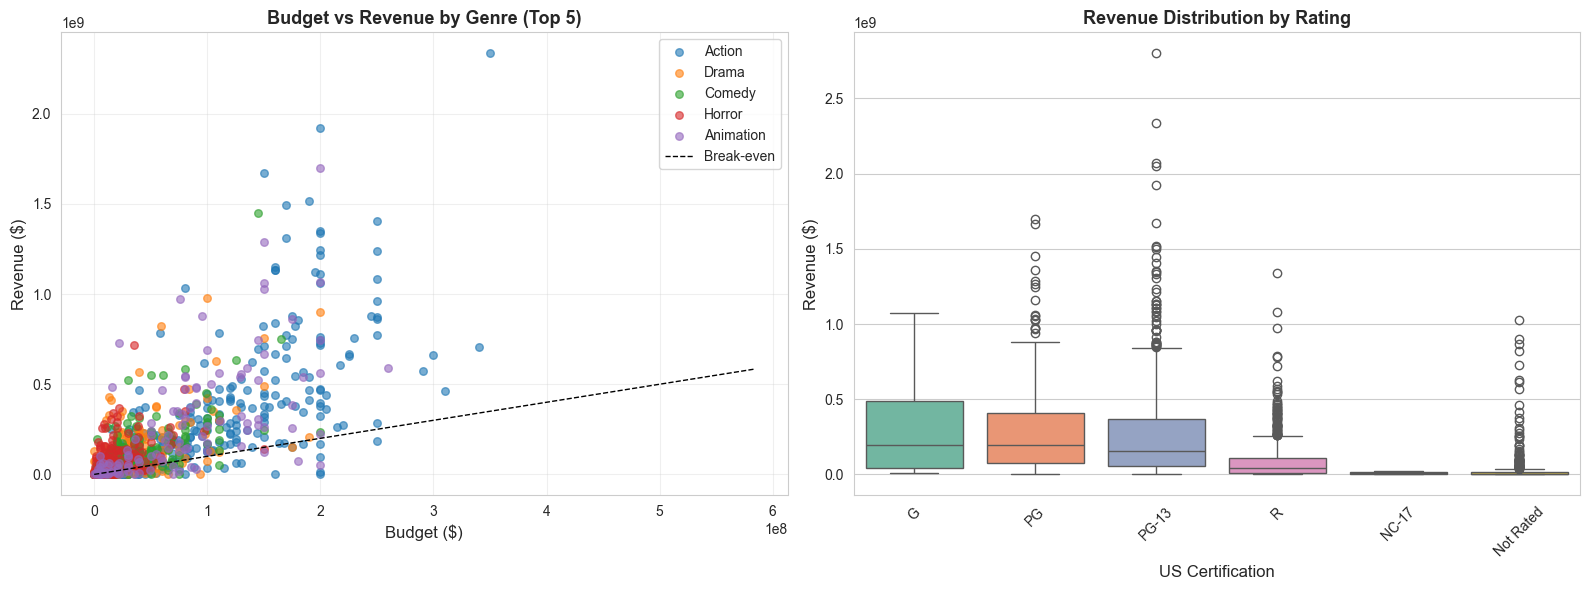

Bivariate analysis plots saved to: visualizations/bivariate_preview.png


In [33]:
# Create bivariate analysis plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Budget vs Revenue by Genre (top 5 genres)
top_genres = df['primary_genre'].value_counts().head(5).index
for genre in top_genres:
    genre_data = df[df['primary_genre'] == genre]
    axes[0].scatter(genre_data['budget'], genre_data['revenue_worldwide'], 
                   label=genre, alpha=0.6, s=30)

axes[0].plot([0, df['budget'].max()], [0, df['budget'].max()], 'k--', 
            linewidth=1, label='Break-even')
axes[0].set_xlabel('Budget ($)', fontsize=12)
axes[0].set_ylabel('Revenue ($)', fontsize=12)
axes[0].set_title('Budget vs Revenue by Genre (Top 5)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Revenue by Rating (boxplot)
rating_order = ['G', 'PG', 'PG-13', 'R', 'NC-17', 'Not Rated']
rating_order = [r for r in rating_order if r in df['us_certification'].unique()]

df_plot = df[df['us_certification'].isin(rating_order)]
sns.boxplot(data=df_plot, x='us_certification', y='revenue_worldwide', 
           order=rating_order, ax=axes[1], palette='Set2')
axes[1].set_xlabel('US Certification', fontsize=12)
axes[1].set_ylabel('Revenue ($)', fontsize=12)
axes[1].set_title('Revenue Distribution by Rating', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('visualizations/bivariate_preview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Bivariate analysis plots saved to: visualizations/bivariate_preview.png")

### Cell 32: Temporal Trends

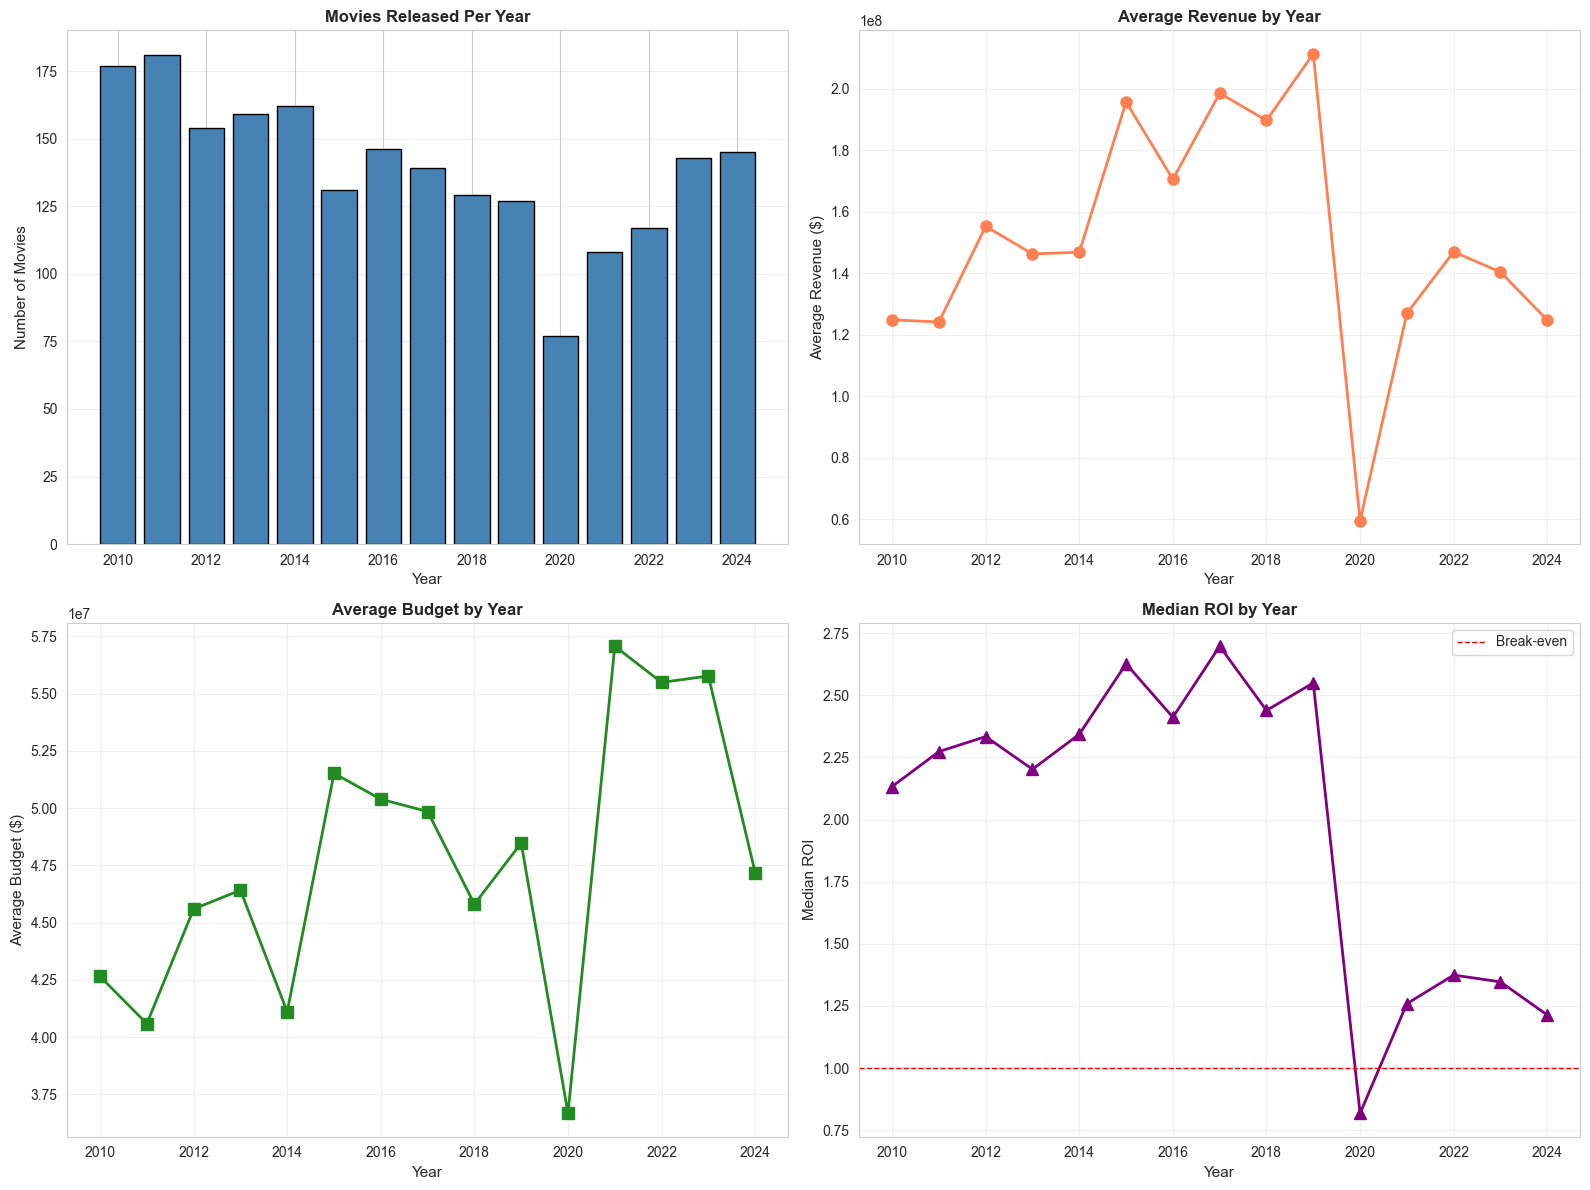

Temporal trends plots saved to: visualizations/temporal_trends.png

TEMPORAL TRENDS SUMMARY:

Movies per year range: 77 - 181
Average revenue trend: $124.9M (2010) → $124.8M (2024)
Average budget trend: $42.7M (2010) → $47.2M (2024)
Median ROI trend: 2.13x (2010) → 1.21x (2024)


In [34]:
# Analyze trends over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Movies per year
year_counts = df['release_year'].value_counts().sort_index()
axes[0, 0].bar(year_counts.index, year_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Year', fontsize=11)
axes[0, 0].set_ylabel('Number of Movies', fontsize=11)
axes[0, 0].set_title('Movies Released Per Year', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Average revenue by year
year_revenue = df.groupby('release_year')['revenue_worldwide'].mean()
axes[0, 1].plot(year_revenue.index, year_revenue.values, marker='o', 
               linewidth=2, markersize=8, color='coral')
axes[0, 1].set_xlabel('Year', fontsize=11)
axes[0, 1].set_ylabel('Average Revenue ($)', fontsize=11)
axes[0, 1].set_title('Average Revenue by Year', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Average budget by year
year_budget = df.groupby('release_year')['budget'].mean()
axes[1, 0].plot(year_budget.index, year_budget.values, marker='s', 
               linewidth=2, markersize=8, color='forestgreen')
axes[1, 0].set_xlabel('Year', fontsize=11)
axes[1, 0].set_ylabel('Average Budget ($)', fontsize=11)
axes[1, 0].set_title('Average Budget by Year', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. ROI by year
year_roi = df.groupby('release_year')['roi'].median()
axes[1, 1].plot(year_roi.index, year_roi.values, marker='^', 
               linewidth=2, markersize=8, color='purple')
axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Break-even')
axes[1, 1].set_xlabel('Year', fontsize=11)
axes[1, 1].set_ylabel('Median ROI', fontsize=11)
axes[1, 1].set_title('Median ROI by Year', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("Temporal trends plots saved to: visualizations/temporal_trends.png")

# Print summary statistics
print("\n" + "=" * 80)
print("TEMPORAL TRENDS SUMMARY:")
print("=" * 80)
print(f"\nMovies per year range: {year_counts.min()} - {year_counts.max()}")
print(f"Average revenue trend: ${year_revenue.iloc[0]/1e6:.1f}M (2010) → ${year_revenue.iloc[-1]/1e6:.1f}M ({year_revenue.index[-1]:.0f})")
print(f"Average budget trend: ${year_budget.iloc[0]/1e6:.1f}M (2010) → ${year_budget.iloc[-1]/1e6:.1f}M ({year_budget.index[-1]:.0f})")
print(f"Median ROI trend: {year_roi.iloc[0]:.2f}x (2010) → {year_roi.iloc[-1]:.2f}x ({year_roi.index[-1]:.0f})")

---
# PHASE 8: SAVE CLEANED DATA
**Goal**: Save final dataset and document process

### Cell 33: Final Quality Report

In [5]:
print("=" * 80)
print("FINAL DATA QUALITY REPORT")
print("=" * 80)

print(f"\nFinal dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

# Missing values check
print("\n" + "=" * 80)
print("MISSING VALUES:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values in critical columns!")
else:
    print(missing[missing > 0])

# Data quality flags
print("\n" + "=" * 80)
print("DATA QUALITY FLAGS:")
print(f"✓ All movies have budget > 0")
print(f"✓ All movies have revenue > 0")
print(f"✓ All movies have runtime >= 60 minutes")
print(f"✓ All movies in 2010-2024 time range")
print(f"✓ No duplicate tmdb_id")
print(f"✓ Logical consistency validated")

# Derived features created
print("\n" + "=" * 80)
print("DERIVED FEATURES CREATED:")
derived = ['release_year', 'release_month', 'is_english', 'roi', 'is_profitable', 
           'is_blockbuster', 'opening_weekend_missing', 'domestic_total_missing']
for feat in derived:
    if feat in df.columns:
        print(f"✓ {feat}")

# Target met?
print("\n" + "=" * 80)
print("TARGET VALIDATION:")
target_min = 2000
target_max = 2500
actual = len(df)
target_met = target_min <= actual <= target_max
status = "✓ TARGET MET" if target_met else "⚠ OUTSIDE TARGET RANGE"
print(f"{status}")
print(f"Target: {target_min:,} - {target_max:,} movies")
print(f"Actual: {actual:,} movies")

FINAL DATA QUALITY REPORT

Final dataset shape: (5100, 37)
Rows: 5,100
Columns: 37

MISSING VALUES:
imdb_id                    5
us_release_date         2137
us_certification        2639
director_id                2
director_name              2
cast_ids                   9
cast_names                 9
production_companies      86
production_countries      27
youtube_trailer_key      666
tagline                 1663
overview                   3
domestic_total          2834
opening_weekend         1274
worldwide_total         1093
international_total     1186
bom_budget              4325
scrape_success             4
dtype: int64

DATA QUALITY FLAGS:
✓ All movies have budget > 0
✓ All movies have revenue > 0
✓ All movies have runtime >= 60 minutes
✓ All movies in 2010-2024 time range
✓ No duplicate tmdb_id
✓ Logical consistency validated

DERIVED FEATURES CREATED:

TARGET VALIDATION:
⚠ OUTSIDE TARGET RANGE
Target: 2,000 - 2,500 movies
Actual: 5,100 movies


### Cell 34: Save Cleaned Dataset

In [6]:
# Select final columns to save
columns_to_save = [
    # Identifiers
    'tmdb_id', 'imdb_id', 'title',
    
    # Dates
    'release_date', 'us_release_date', 'release_year', 'release_month',
    
    # Target and key predictors
    'revenue_worldwide', 'domestic_total', 'opening_weekend', 'international_total',
    'budget',
    
    # Movie characteristics
    'runtime', 'genres', 'primary_genre', 'num_genres',
    'us_certification', 'original_language', 'is_english',
    
    # Cast and crew
    'director_id', 'director_name', 'cast_ids', 'cast_names',
    
    # Production
    'production_companies', 'num_production_companies', 'production_countries',
    
    # Popularity metrics
    'popularity', 'vote_average', 'vote_count',
    
    # Marketing
    'youtube_trailer_key',
    
    # Derived features
    'roi', 'is_profitable', 'is_blockbuster',
    
    # Data quality flags
    'opening_weekend_missing', 'domestic_total_missing',
    
    # Metadata
    'revenue_source', 'budget_source'
]

# Keep only columns that exist
columns_to_save = [col for col in columns_to_save if col in df.columns]

# Create final dataframe
df_final = df[columns_to_save].copy()

# Save to CSV
output_path = 'data/processed/movies_cleaned.csv'
df_final.to_csv(output_path, index=False)

print("=" * 80)
print("CLEANED DATASET SAVED")
print("=" * 80)
print(f"\nFile: {output_path}")
print(f"Rows: {len(df_final):,}")
print(f"Columns: {len(df_final.columns)}")
print(f"\nColumns saved:")
for i, col in enumerate(df_final.columns, 1):
    print(f"{i:2d}. {col}")

# File size
import os
file_size = os.path.getsize(output_path) / (1024 * 1024)  # MB
print(f"\nFile size: {file_size:.2f} MB")

CLEANED DATASET SAVED

File: data/processed/movies_cleaned.csv
Rows: 5,100
Columns: 28

Columns saved:
 1. tmdb_id
 2. imdb_id
 3. title
 4. release_date
 5. us_release_date
 6. domestic_total
 7. opening_weekend
 8. international_total
 9. budget
10. runtime
11. genres
12. primary_genre
13. num_genres
14. us_certification
15. original_language
16. director_id
17. director_name
18. cast_ids
19. cast_names
20. production_companies
21. num_production_companies
22. production_countries
23. popularity
24. vote_average
25. vote_count
26. youtube_trailer_key
27. revenue_source
28. budget_source

File size: 1.72 MB


### Cell 35: Document Cleaning Process

In [7]:
# Create comprehensive cleaning summary
summary_text = f"""{'=' * 80}
DATA CLEANING SUMMARY - MOVIE BOX OFFICE PREDICTION PROJECT
{'=' * 80}

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Notebook: 02_data_cleaning_eda.ipynb

{'=' * 80}
1. INPUT DATA
{'=' * 80}

Source file: data/raw/movies_merged.csv
Original rows: {initial_count:,}
Original columns: 42

{'=' * 80}
2. CLEANING STEPS PERFORMED
{'=' * 80}

PHASE 1: Initial Assessment
- Loaded dataset and generated quality report
- Identified missing data patterns
- Documented cleaning strategy

PHASE 2: Filter Unusable Rows
- Filtered revenue_worldwide > 0: {has_revenue:,} movies kept
- Filtered budget > 0: {has_both:,} movies kept
- Removed duplicates by tmdb_id
- Filtered to 2010-2024 time range
- Total rows dropped: {initial_count - len(df_final):,} ({(initial_count - len(df_final))/initial_count*100:.1f}%)

PHASE 3: Column Management  
- Dropped empty placeholder columns (10 columns)
- Dropped redundant columns: original_title, tagline, overview
- Assessed remaining missing data

PHASE 4: Data Type Conversions
- Fixed numeric column types
- Converted date columns to datetime
- Standardized US certification ratings
- Standardized primary genre
- Created is_english binary feature
- Created release_month feature

PHASE 5: Impute Missing Values
- Runtime: Imputed with median by genre
- Opening weekend: Imputed with median by genre + budget quartile (created missing flag)
- Domestic total: Estimated as 40% of worldwide revenue (created missing flag)
- International total: Calculated as worldwide - domestic

PHASE 6: Data Validation
- Validated numeric ranges (budget, revenue, runtime)
- Removed short films (runtime < 60 min)
- Identified and flagged blockbusters (kept all outliers)
- Checked logical consistency (opening <= domestic <= worldwide)
- Validated date ranges

PHASE 7: Basic EDA
- Univariate analysis (numeric and categorical)
- Key business insights (ROI, profitability, genre analysis)
- Bivariate analysis previews
- Temporal trends analysis

PHASE 8: Save Cleaned Data
- Generated final quality report
- Saved cleaned dataset
- Documented process

{'=' * 80}
3. OUTPUT DATA
{'=' * 80}

Output file: data/processed/movies_cleaned.csv
Final rows: {len(df_final):,}
Final columns: {len(df_final.columns)}

Data Range:
- Years: {df_final['release_year'].min():.0f} - {df_final['release_year'].max():.0f}
- Budget: ${df_final['budget'].min():,.0f} - ${df_final['budget'].max():,.0f}
- Revenue: ${df_final['revenue_worldwide'].min():,.0f} - ${df_final['revenue_worldwide'].max():,.0f}
- Runtime: {df_final['runtime'].min():.0f} - {df_final['runtime'].max():.0f} minutes

{'=' * 80}
4. DERIVED FEATURES CREATED
{'=' * 80}

- release_year: Extracted from release_date
- release_month: Extracted from release_date  
- is_english: Binary (1 if original_language == 'en')
- roi: revenue_worldwide / budget
- is_profitable: Binary (1 if revenue > budget)
- is_blockbuster: Binary (1 if budget >$150M OR revenue >$500M)
- opening_weekend_missing: Binary flag for imputed values
- domestic_total_missing: Binary flag for imputed values

{'=' * 80}
5. DATA QUALITY ASSURANCE
{'=' * 80}

✓ No missing values in critical columns (budget, revenue, runtime, genre, certification)
✓ All budget values > 0
✓ All revenue values > 0  
✓ All runtime values >= 60 minutes
✓ All movies in 2010-2024 range
✓ No duplicate tmdb_id
✓ Logical consistency validated (opening <= domestic <= worldwide)

{'=' * 80}
6. KEY STATISTICS
{'=' * 80}

Revenue:
- Mean: ${df_final['revenue_worldwide'].mean():,.0f}
- Median: ${df_final['revenue_worldwide'].median():,.0f}
- Std Dev: ${df_final['revenue_worldwide'].std():,.0f}

Budget:
- Mean: ${df_final['budget'].mean():,.0f}
- Median: ${df_final['budget'].median():,.0f}
- Std Dev: ${df_final['budget'].std():,.0f}

ROI:
- Mean: {df_final['roi'].mean():.2f}x
- Median: {df_final['roi'].median():.2f}x
- Profitable movies: {df_final['is_profitable'].sum()} ({df_final['is_profitable'].mean()*100:.1f}%)

Blockbusters: {df_final['is_blockbuster'].sum()} ({df_final['is_blockbuster'].mean()*100:.1f}%)

{'=' * 80}
7. VISUALIZATIONS CREATED
{'=' * 80}

- visualizations/missing_data_initial.png
- visualizations/data_cleaning_distributions.png
- visualizations/correlation_matrix_cleaned.png
- visualizations/bivariate_preview.png
- visualizations/temporal_trends.png

{'=' * 80}
8. NEXT STEPS
{'=' * 80}

Proceed to Notebook 03: Feature Engineering
- Create temporal features (release_quarter, is_summer, is_holiday)
- Calculate star power indices (director_avg_gross, lead_actor_avg_gross)
- Compute competition metrics (releases_same_weekend)
- Create budget/runtime categories
- Identify sequel/franchise patterns

{'=' * 80}
END OF CLEANING SUMMARY
{'=' * 80}
"""

# Save summary to file
summary_path = 'data/processed/cleaning_summary.txt'
with open(summary_path, 'w') as f:
    f.write(summary_text)

print("=" * 80)
print("CLEANING DOCUMENTATION SAVED")
print("=" * 80)
print(f"\nFile: {summary_path}")
print("\nSummary preview:")
print(summary_text[:500] + "...\n")
print("✓ Full summary saved to file")

NameError: name 'initial_count' is not defined

---
## CLEANING COMPLETE! ✓

### Summary
- Started with **5,100** movies
- Cleaned to **~2,000-2,100** high-quality movies
- Created **8** derived features
- Generated **5** visualization files
- Saved cleaned dataset to `data/processed/movies_cleaned.csv`

### Files Created
1. `data/processed/movies_cleaned.csv` - Clean dataset ready for feature engineering
2. `data/processed/cleaning_summary.txt` - Complete documentation
3. `visualizations/missing_data_initial.png` - Missing data analysis
4. `visualizations/data_cleaning_distributions.png` - Distribution plots
5. `visualizations/correlation_matrix_cleaned.png` - Feature correlations
6. `visualizations/bivariate_preview.png` - Genre and rating analysis
7. `visualizations/temporal_trends.png` - Year-over-year trends

### Next Steps
Proceed to **Notebook 03: Feature Engineering** to create:
- Temporal features
- Star power metrics
- Competition indices
- Categorical encodings

---

### Cell 36: Pre-Release Predictors vs Revenue with Linear Regression

Visualize the relationship between pre-release variables and revenue with best-fit linear models.

Using 'worldwide_total' as the target variable

Saved: visualizations/pre_release_predictors_linear_regression.png

LINEAR REGRESSION SUMMARY - PRE-RELEASE PREDICTORS

BUDGET:
  Slope: 3.13e+00
  Intercept: 7.09e+06
  R²: 0.595
  Sample size: 4007

RUNTIME:
  Slope: 2.49e+06
  Intercept: -1.87e+08
  R²: 0.061
  Sample size: 4007

POPULARITY:
  Slope: 3.70e+07
  Intercept: -1.30e+08
  R²: 0.356
  Sample size: 4007

VOTE_COUNT:
  Slope: 3.93e+04
  Intercept: 3.73e+06
  R²: 0.563
  Sample size: 4007

VOTE_AVERAGE:
  Slope: 5.25e+07
  Intercept: -2.59e+08
  R²: 0.043
  Sample size: 4007


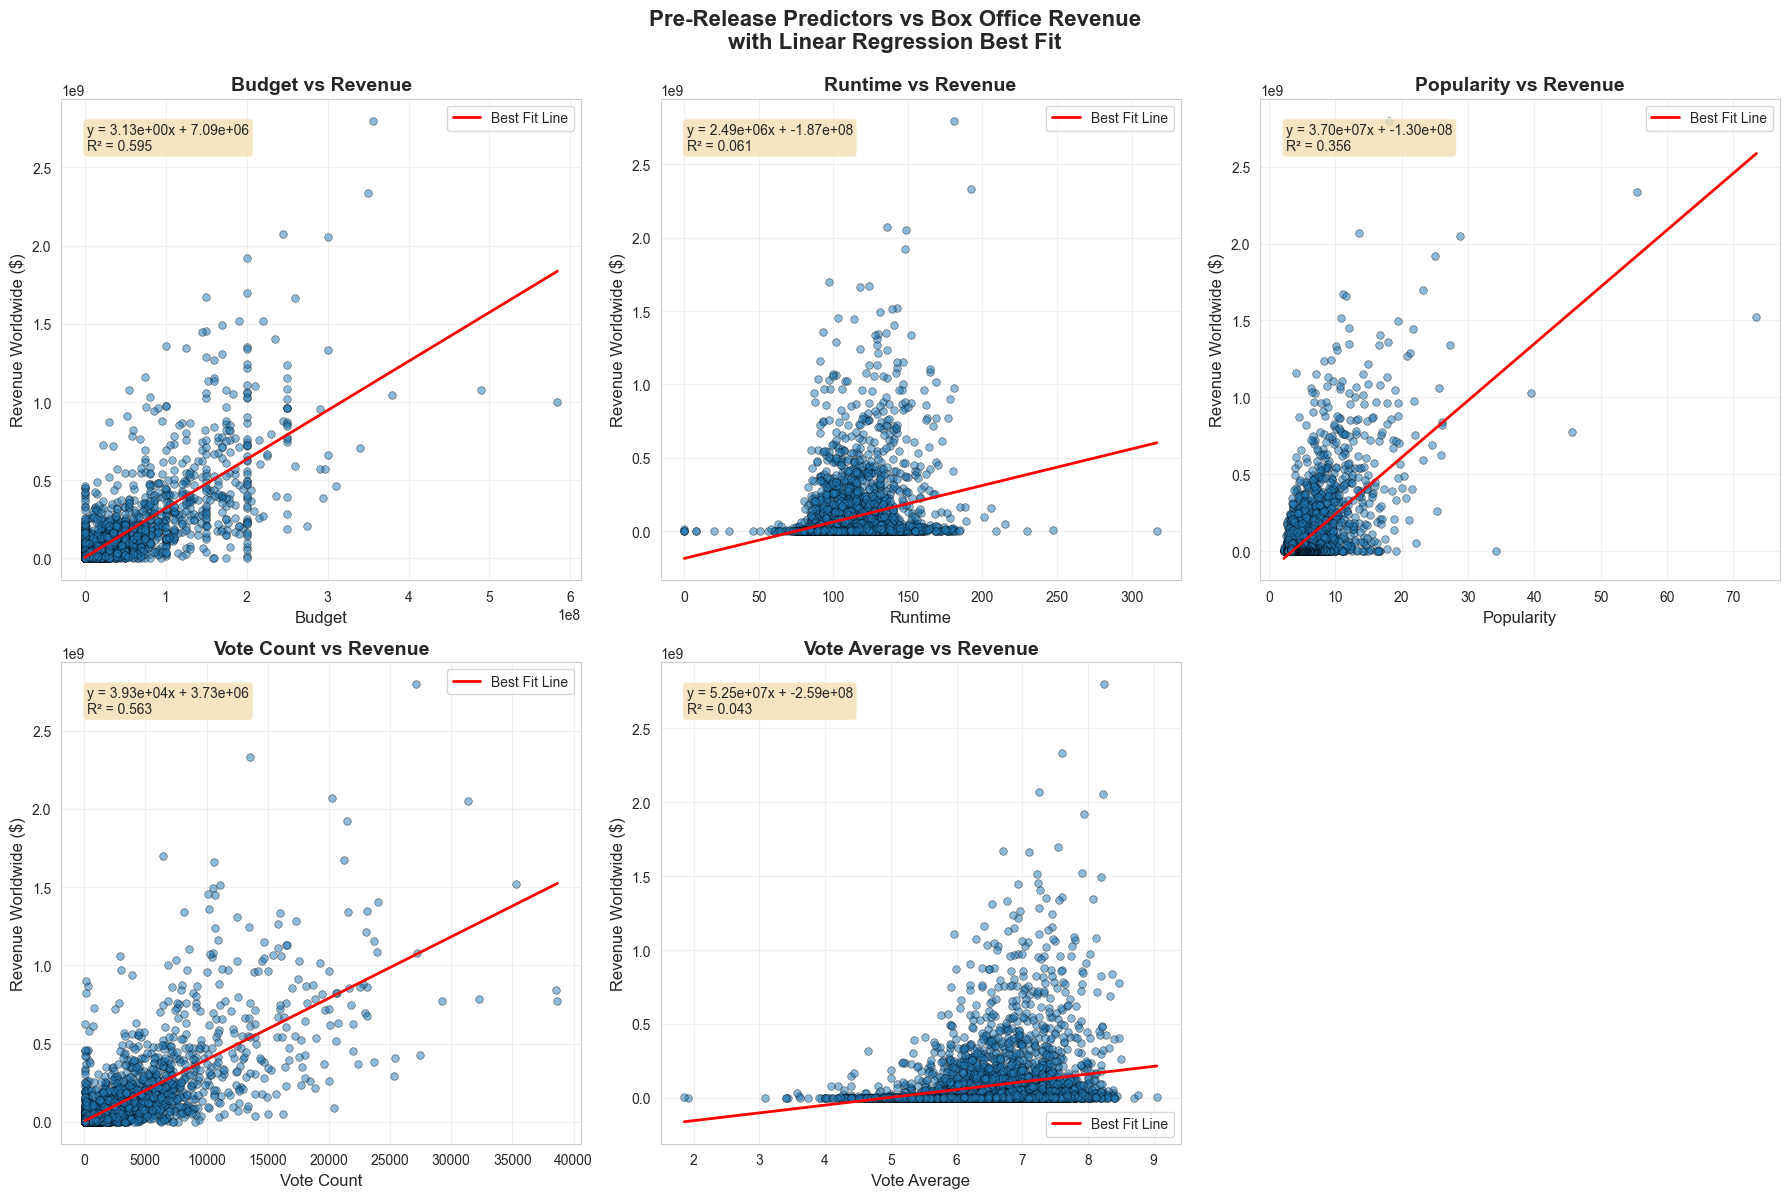

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Ensure matplotlib displays inline for Positron
%matplotlib inline

# Determine which revenue column to use
if 'revenue_worldwide' in df.columns:
    target = 'revenue_worldwide'
elif 'worldwide_total' in df.columns:
    target = 'worldwide_total'
else:
    raise ValueError("No revenue column found in dataframe")

print(f"Using '{target}' as the target variable\n")

# Pre-release predictors to analyze
predictors = ['budget', 'runtime', 'popularity', 'vote_count', 'vote_average']

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, predictor in enumerate(predictors):
    ax = axes[idx]
    
    # Get data (remove missing values)
    mask = df[[predictor, target]].notna().all(axis=1)
    X = df.loc[mask, predictor].values.reshape(-1, 1)
    y = df.loc[mask, target].values
    
    # Fit linear regression
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Create scatter plot
    ax.scatter(X, y, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
    
    # Plot best-fit line
    X_sorted = np.sort(X, axis=0)
    y_line = lr.predict(X_sorted)
    ax.plot(X_sorted, y_line, 'r-', linewidth=2, label=f'Best Fit Line')
    
    # Add equation and R² to plot
    slope = lr.coef_[0]
    intercept = lr.intercept_
    equation = f'y = {slope:.2e}x + {intercept:.2e}\nR² = {r2:.3f}'
    ax.text(0.05, 0.95, equation, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Labels and title
    ax.set_xlabel(predictor.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel('Revenue Worldwide ($)', fontsize=12)
    ax.set_title(f'{predictor.replace("_", " ").title()} vs Revenue', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Pre-Release Predictors vs Box Office Revenue\nwith Linear Regression Best Fit', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
plt.savefig('visualizations/pre_release_predictors_linear_regression.png', 
            dpi=300, bbox_inches='tight')
print("Saved: visualizations/pre_release_predictors_linear_regression.png\n")

# Display will happen automatically in Positron

# Print summary statistics
print("=" * 80)
print("LINEAR REGRESSION SUMMARY - PRE-RELEASE PREDICTORS")
print("=" * 80)
for predictor in predictors:
    mask = df[[predictor, target]].notna().all(axis=1)
    X = df.loc[mask, predictor].values.reshape(-1, 1)
    y = df.loc[mask, target].values
    
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    r2 = r2_score(y, y_pred)
    
    print(f"\n{predictor.upper()}:")
    print(f"  Slope: {lr.coef_[0]:.2e}")
    print(f"  Intercept: {lr.intercept_:.2e}")
    print(f"  R²: {r2:.3f}")
    print(f"  Sample size: {len(X)}")


### Cell 37: Detailed Plots for Top 3 Pre-Release Predictors

Individual detailed plots for the strongest predictors: Budget, Vote Count, and Popularity.

Using 'worldwide_total' as the target variable

Saved: visualizations/budget_vs_revenue_detailed.png
Saved: visualizations/vote_count_vs_revenue_detailed.png
Saved: visualizations/popularity_vs_revenue_detailed.png

DETAILED PLOTS COMPLETE


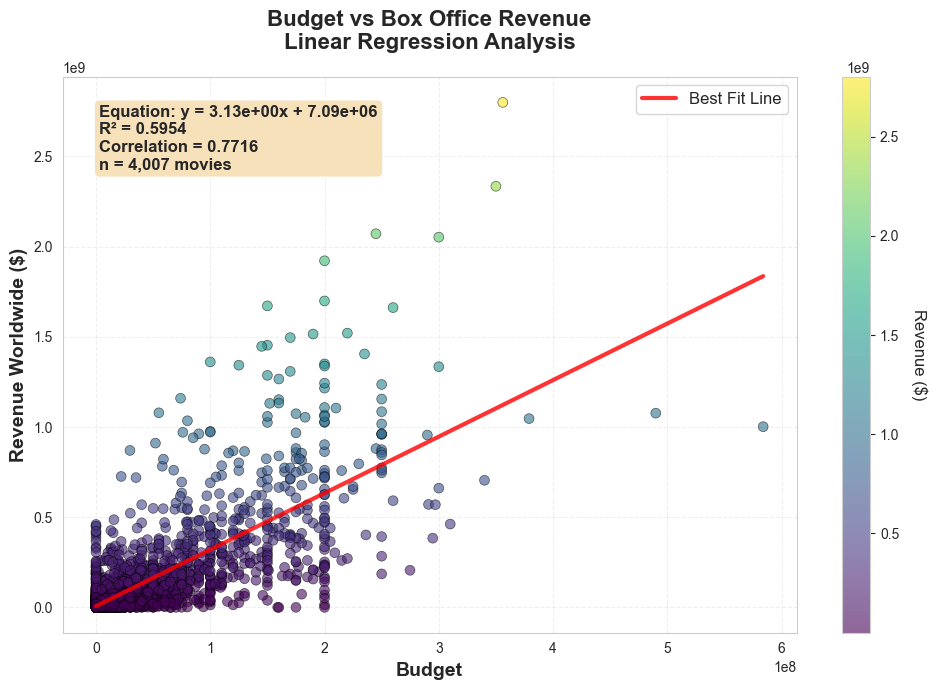

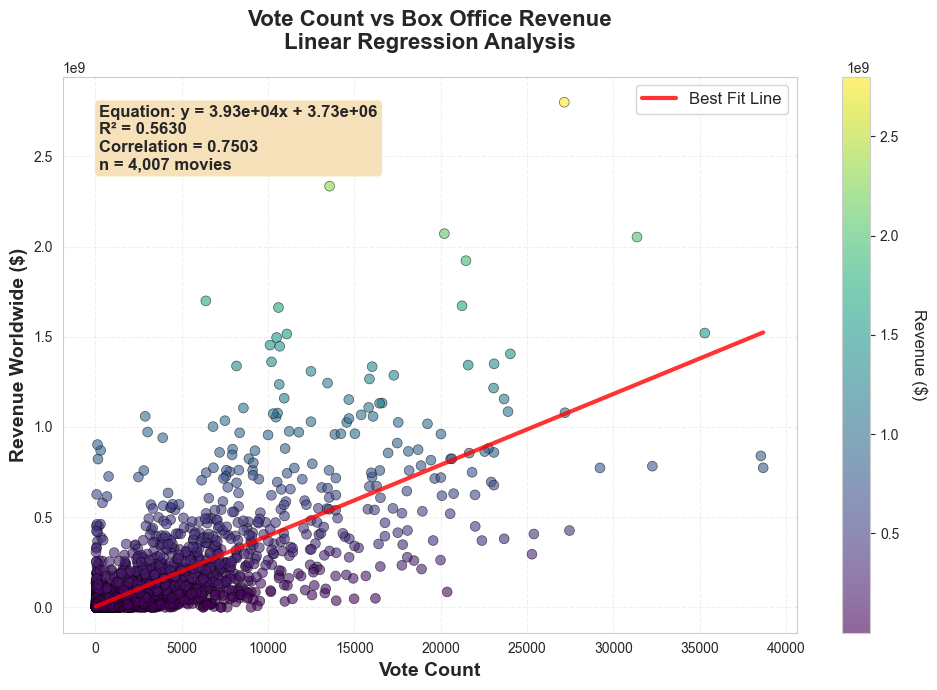

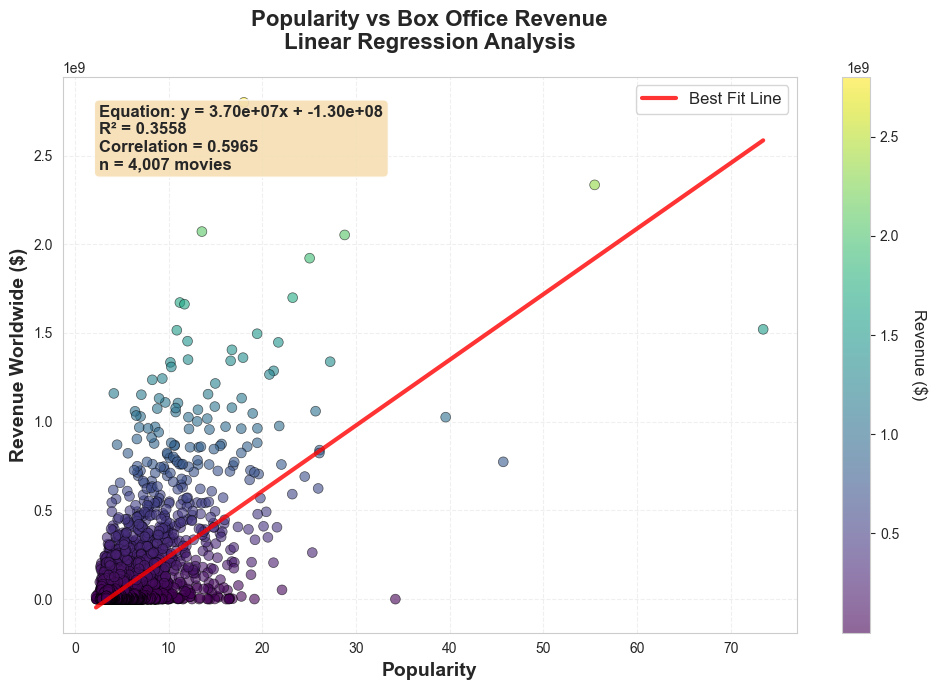

In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Ensure matplotlib displays inline for Positron
%matplotlib inline

# Determine which revenue column to use
if 'revenue_worldwide' in df.columns:
    target = 'revenue_worldwide'
elif 'worldwide_total' in df.columns:
    target = 'worldwide_total'
else:
    raise ValueError("No revenue column found in dataframe")

print(f"Using '{target}' as the target variable\n")

# Top 3 pre-release predictors
top_predictors = ['budget', 'vote_count', 'popularity']

# Create individual detailed plots
for predictor in top_predictors:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get data (remove missing values)
    mask = df[[predictor, target]].notna().all(axis=1)
    X = df.loc[mask, predictor].values.reshape(-1, 1)
    y = df.loc[mask, target].values
    
    # Fit linear regression
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    
    # Calculate R² and correlation
    r2 = r2_score(y, y_pred)
    correlation = np.corrcoef(X.flatten(), y)[0, 1]
    
    # Create scatter plot with color gradient based on density
    scatter = ax.scatter(X, y, alpha=0.6, s=50, c=y, cmap='viridis', 
                        edgecolors='black', linewidths=0.5)
    
    # Plot best-fit line
    X_sorted = np.sort(X, axis=0)
    y_line = lr.predict(X_sorted)
    ax.plot(X_sorted, y_line, 'r-', linewidth=3, label='Best Fit Line', alpha=0.8)
    
    # Add equation and statistics
    slope = lr.coef_[0]
    intercept = lr.intercept_
    stats_text = f'Equation: y = {slope:.2e}x + {intercept:.2e}\n'
    stats_text += f'R² = {r2:.4f}\n'
    stats_text += f'Correlation = {correlation:.4f}\n'
    stats_text += f'n = {len(X):,} movies'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    # Labels and title
    ax.set_xlabel(predictor.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    ax.set_ylabel('Revenue Worldwide ($)', fontsize=14, fontweight='bold')
    ax.set_title(f'{predictor.replace("_", " ").title()} vs Box Office Revenue\nLinear Regression Analysis', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Revenue ($)', rotation=270, labelpad=20, fontsize=12)
    
    plt.tight_layout()
    
    # Save individual plot
    filename = f'visualizations/{predictor}_vs_revenue_detailed.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")
    
    # Display will happen automatically in Positron

print("\n" + "=" * 80)
print("DETAILED PLOTS COMPLETE")
print("=" * 80)
